国家列表: ['Norway', 'Israel', 'India', 'France', 'United.Kingdom', 'Italy', 'Poland', 'Austria', 'Japan', 'Argentina', 'Korea', 'Switzerland', 'Russia', 'China', 'Saudi.Arabia', 'Sweden', 'Singapore', 'Germany', 'Belgium', 'Mexico', 'Thailand', 'Brazil', 'Türkiye', 'Indonesia', 'Netherlands', 'Canada', 'Ireland', 'United.States', 'Spain']

数据示例（前5行）：
           Norway    Israel     India    France  United.Kingdom     Italy  \
Date                                                                        
1月 2001       NaN       NaN       NaN       NaN             NaN       NaN   
2月 2001  0.739466 -0.292277 -0.000409  0.076148        0.024331  0.305515   
3月 2001  0.248562  0.242810 -0.141616  0.248794        0.245804  0.053752   
4月 2001  0.576571  0.170260  0.259519  0.374771        0.254242  0.295751   
5月 2001  0.619858  0.242291  0.295725  0.524983        0.705165  0.244895   

           Poland   Austria     Japan  Argentina  ...    Mexico  Thailand  \
Date                             

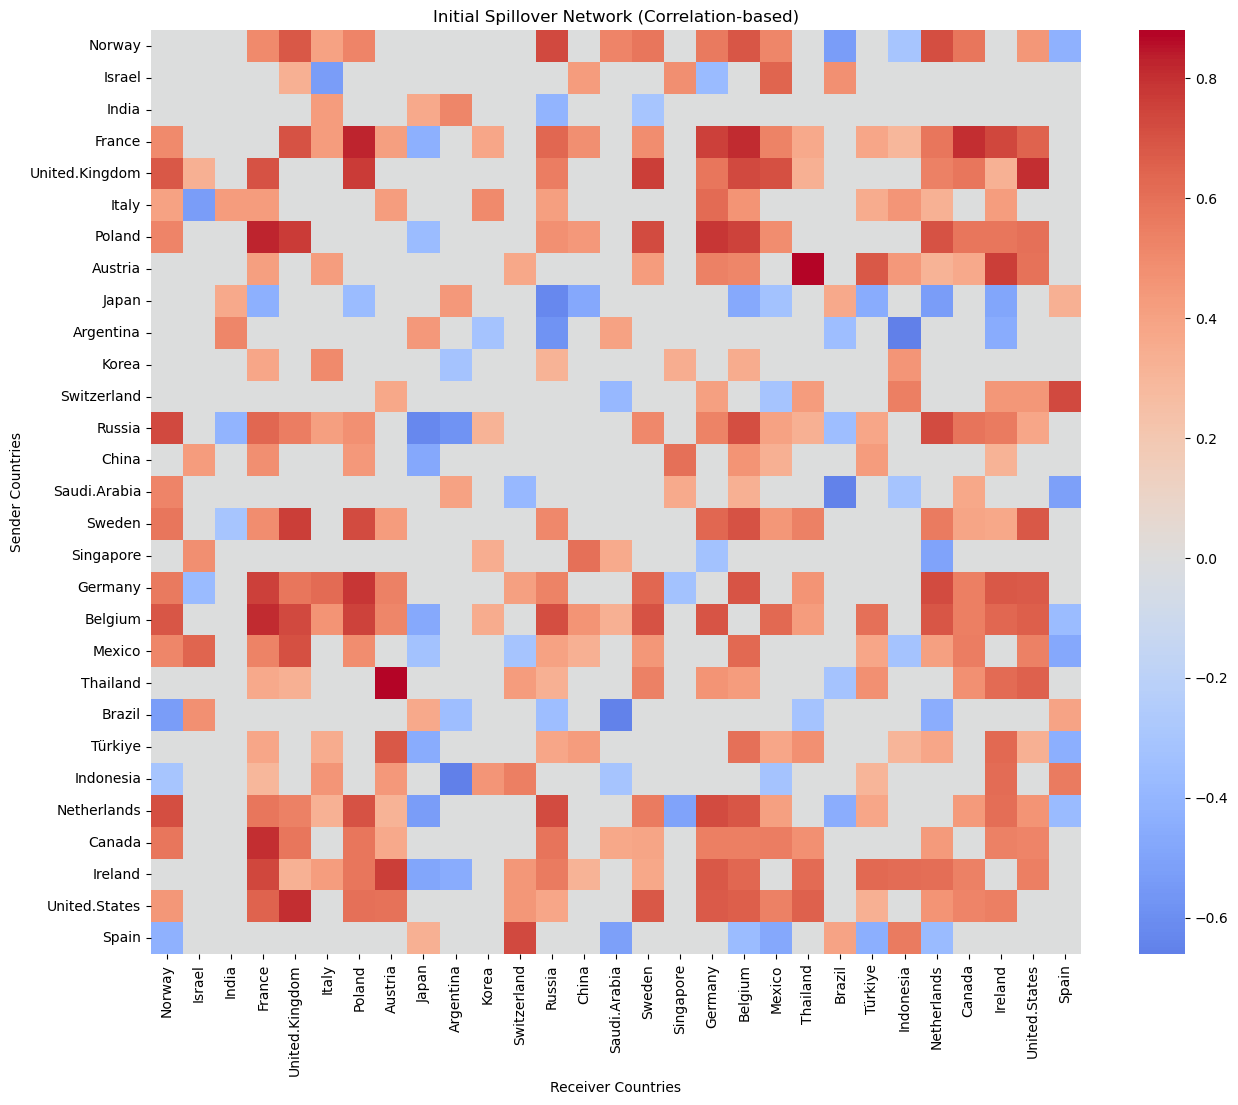

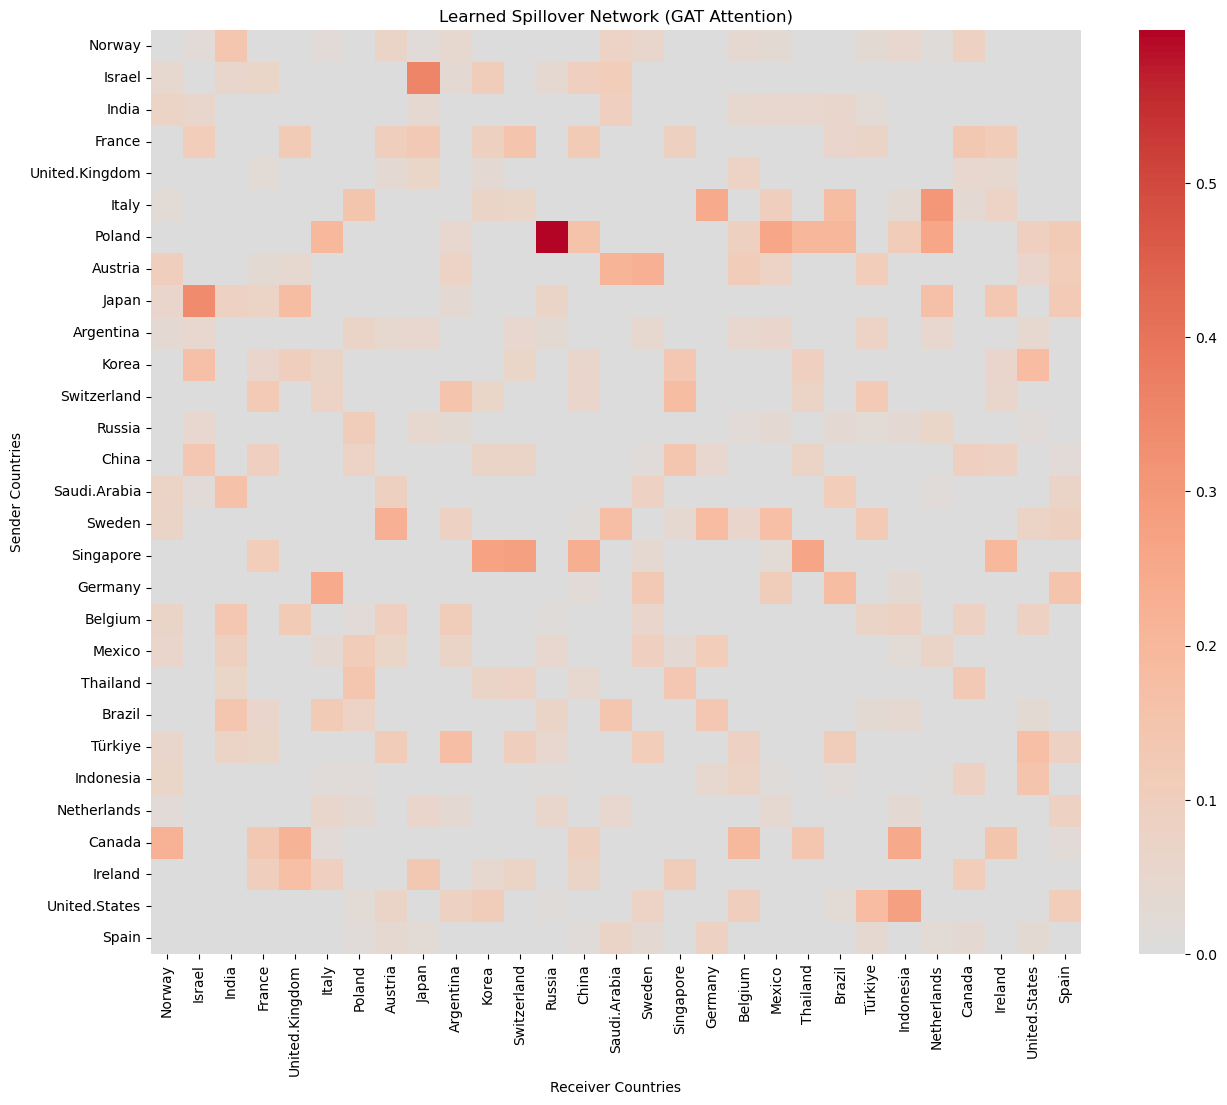

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ======= 1. 加载和预处理数据 =======
DATA_PATH = "C:/Users/rog/Desktop/Study/统模/Global-Inflation-Spillovers/new_data/final_cpi_data_filtered.csv"

# 读取数据（时间作为行索引，国家作为列）
data = pd.read_csv(DATA_PATH, index_col=0)  # index_col=0表示时间是行索引
countries = data.columns.tolist()  # 获取国家列表
print("国家列表:", countries)

# 检查数据结构
print("\n数据示例（前5行）：")
print(data.head())

# 标准化数据（按国家标准化）
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)  # 按国家标准化

# 检查数据中是否有NaN或inf
print("\n检查数据是否有NaN或inf值：")
print("NaN的数量:", np.isnan(scaled_data).sum())
print("Inf的数量:", np.isinf(scaled_data).sum())

# 用0填充NaN和inf值
scaled_data = np.nan_to_num(scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

print("\n标准化后数据示例（前5行）：")
print(scaled_data[:5, :])  # 显示前5个时间点，所有国家

# ======= 2. 构建图数据序列 =======
WINDOW_SIZE = 12  # 使用12个月历史数据
EDGE_THRESHOLD = 0.3  # 边相关性阈值

def create_graph_sequence(data, window_size=12):
    graphs = []
    n_times, n_countries = data.shape
    
    for t in range(window_size, n_times-1):  # 保留最后一个时间点作为预测目标
        # 节点特征（当前窗口内的数据）
        node_features = data[t-window_size:t, :].T  # 转置为（国家×时间窗口）
        
        # 边构建（时滞相关系数）
        edge_index = []
        edge_attr = []
        for i in range(n_countries):
            for j in range(n_countries):
                if i != j:
                    # 使用过去window_size数据进行计算
                    x = data[t-window_size:t, i]  # 过去的数据
                    y = data[t-window_size:t, j]  # 另一国家的过去数据
                    valid_mask = ~np.isnan(x) & ~np.isnan(y)
                    if np.sum(valid_mask) >= 6:  # 至少需要6个有效数据点
                        corr = np.corrcoef(x[valid_mask], y[valid_mask])[0, 1]
                        if abs(corr) > EDGE_THRESHOLD:
                            edge_index.append([i, j])
                            edge_attr.append(corr)
        
        # 转换为PyG的Data对象
        graph = Data(
            x=torch.tensor(node_features, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1),
            y=torch.tensor(data[t+1, :], dtype=torch.float)  # 下一期所有国家的通胀率
        )
        graphs.append(graph)
    return graphs

# 创建图序列
graph_sequence = create_graph_sequence(scaled_data, WINDOW_SIZE)
print(f"\n构建的图数量: {len(graph_sequence)}")
print("单图特征示例:", graph_sequence[0])

# ======= 3. 定义GAT模型 =======
class InflationGAT(nn.Module):
    def __init__(self, in_channels, out_channels=1, heads=4):
        super(InflationGAT, self).__init__()
        self.conv1 = GATConv(in_channels, 16, heads=heads, edge_dim=1)
        self.conv2 = GATConv(16*heads, 32, heads=2, edge_dim=1)
        self.predictor = nn.Sequential(
            nn.Linear(32*2, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )
        
    def forward(self, data, return_attention=False):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # 第一层GAT（返回注意力权重）
        x, (edge_index1, att1) = self.conv1(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 第二层GAT
        x, (edge_index2, att2) = self.conv2(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 预测下一期通胀率
        pred = self.predictor(x)
        
        if return_attention:
            # 合并两层注意力权重并取平均
            combined_att = (att1.mean(dim=1) + att2.mean(dim=1)) / 2  # 正确闭合括号
            return pred.squeeze(), combined_att
        return pred.squeeze()

# ======= 4. 训练流程 =======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InflationGAT(in_channels=WINDOW_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

def train(epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for graph in graph_sequence:
            graph = graph.to(device)
            optimizer.zero_grad()
            
            pred = model(graph)
            loss = loss_fn(pred, graph.y)
            
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}")
                break
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if torch.isnan(loss):
            break
            
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(graph_sequence):.4f}')

train(epochs=500)

# ======= 5. 提取并可视化溢出网络 =======
def plot_spillover(matrix, title):
    plt.figure(figsize=(15, 12))
    sns.heatmap(matrix, 
               xticklabels=countries,
               yticklabels=countries,
               cmap="coolwarm",
               center=0,
               annot=False)
    plt.title(title)
    plt.xlabel("Receiver Countries")
    plt.ylabel("Sender Countries")
    plt.show()

# 提取初始网络（基于相关系数）
initial_net = np.zeros((len(countries), len(countries)))
for graph in graph_sequence[:1]:  # 取第一个图的初始关系
    edges = graph.edge_index.cpu().numpy().T
    attrs = graph.edge_attr.cpu().numpy()
    for (src, dst), attr in zip(edges, attrs):
        initial_net[src, dst] = attr
plot_spillover(initial_net, "Initial Spillover Network (Correlation-based)")

# 提取训练后的GAT网络
model.eval()
with torch.no_grad():
    graph = graph_sequence[-1].to(device)
    pred, attention = model(graph, return_attention=True)
    gat_net = np.zeros((len(countries), len(countries)))
    edges = graph.edge_index.cpu().numpy().T
    for (src, dst), att in zip(edges, attention.cpu().numpy()):
        gat_net[src, dst] = att
plot_spillover(gat_net, "Learned Spillover Network (GAT Attention)")


国家列表: ['Norway', 'Israel', 'India', 'France', 'United.Kingdom', 'Italy', 'Poland', 'Austria', 'Japan', 'Argentina', 'Korea', 'Switzerland', 'Russia', 'China', 'Saudi.Arabia', 'Sweden', 'Singapore', 'Germany', 'Belgium', 'Mexico', 'Thailand', 'Brazil', 'Türkiye', 'Indonesia', 'Netherlands', 'Canada', 'Ireland', 'United.States', 'Spain']

数据示例（前5行）：
           Norway    Israel     India    France  United.Kingdom     Italy  \
Date                                                                        
1月 2001       NaN       NaN       NaN       NaN             NaN       NaN   
2月 2001  0.739466 -0.292277 -0.000409  0.076148        0.024331  0.305515   
3月 2001  0.248562  0.242810 -0.141616  0.248794        0.245804  0.053752   
4月 2001  0.576571  0.170260  0.259519  0.374771        0.254242  0.295751   
5月 2001  0.619858  0.242291  0.295725  0.524983        0.705165  0.244895   

           Poland   Austria     Japan  Argentina  ...    Mexico  Thailand  \
Date                             

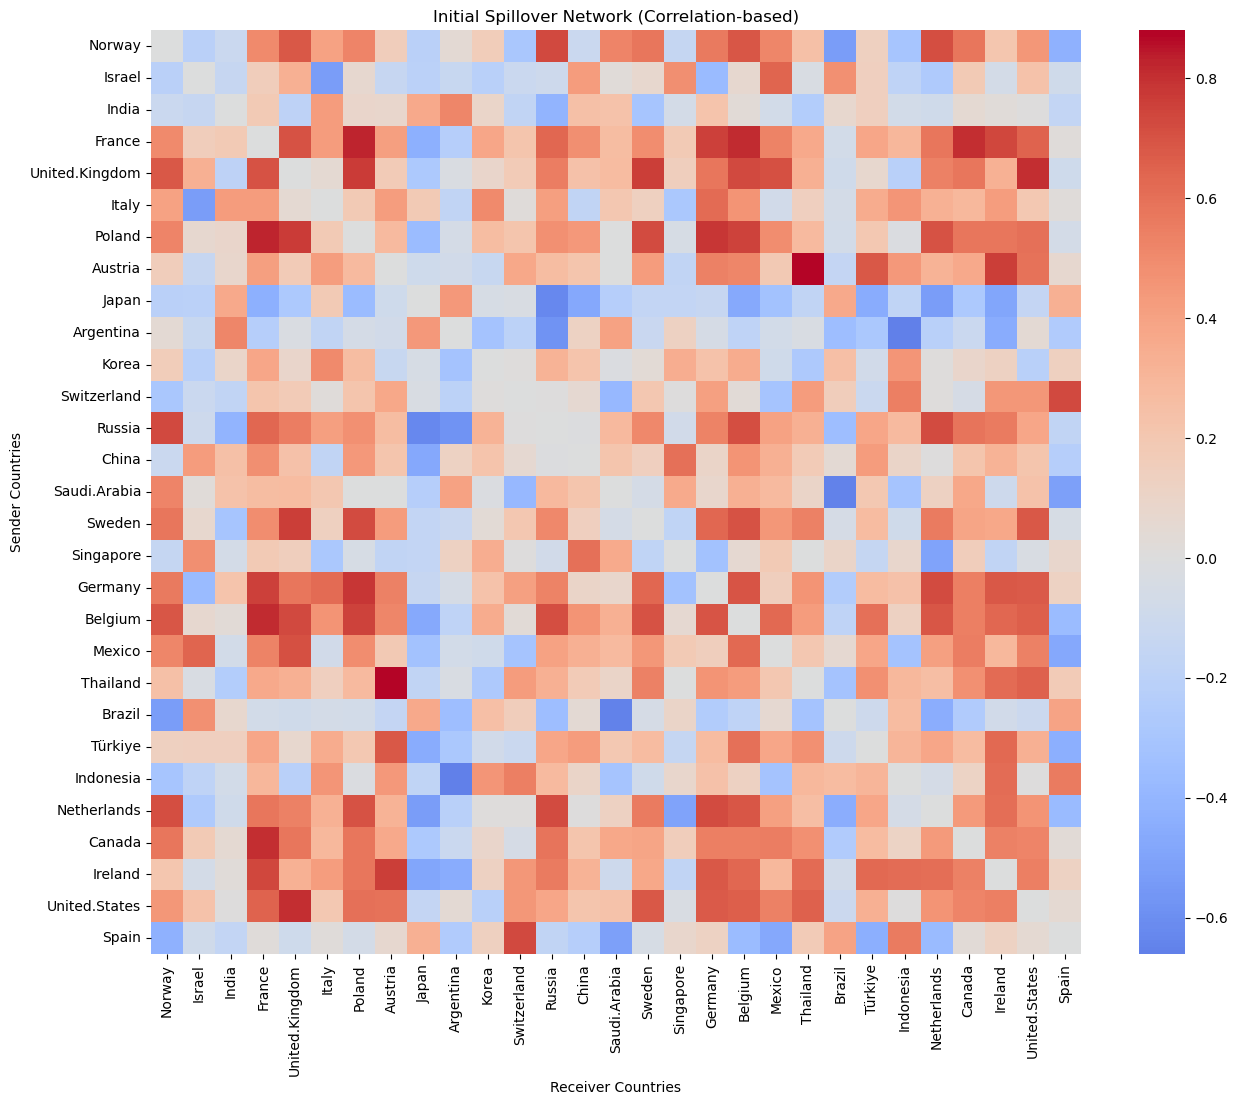

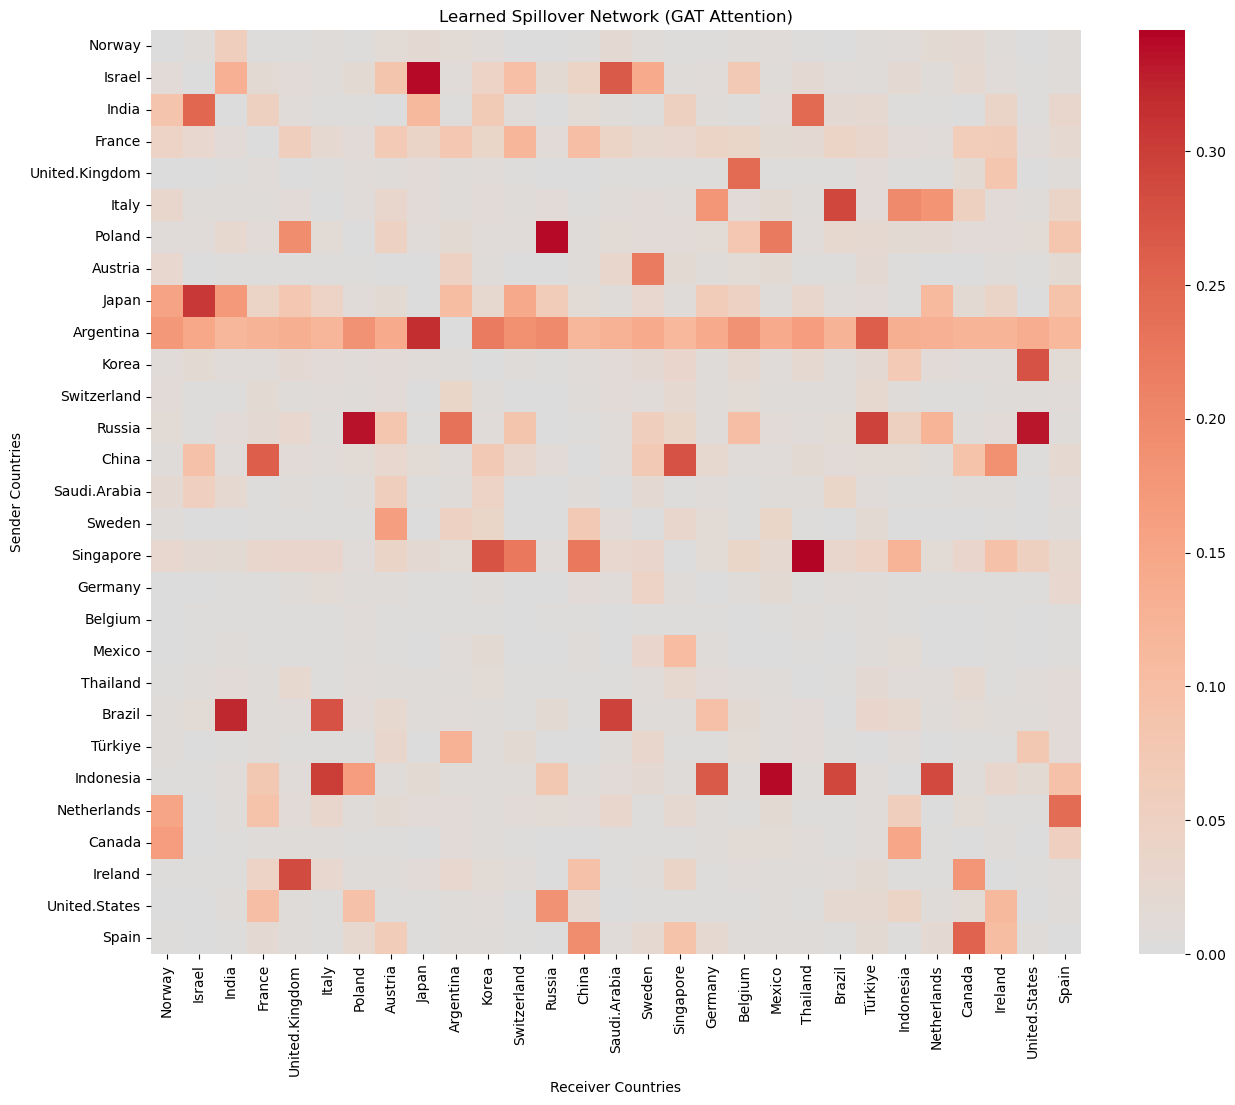

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ======= 1. 加载和预处理数据 =======
DATA_PATH = "C:/Users/rog/Desktop/Study/统模/Global-Inflation-Spillovers/new_data/final_cpi_data_filtered.csv"

# 读取数据（时间作为行索引，国家作为列）
data = pd.read_csv(DATA_PATH, index_col=0)  # index_col=0表示时间是行索引
countries = data.columns.tolist()  # 获取国家列表
print("国家列表:", countries)

# 检查数据结构
print("\n数据示例（前5行）：")
print(data.head())

# 标准化数据（按国家标准化）
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)  # 按国家标准化

# 检查数据中是否有NaN或inf
print("\n检查数据是否有NaN或inf值：")
print("NaN的数量:", np.isnan(scaled_data).sum())
print("Inf的数量:", np.isinf(scaled_data).sum())

# 用0填充NaN和inf值
scaled_data = np.nan_to_num(scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

print("\n标准化后数据示例（前5行）：")
print(scaled_data[:5, :])  # 显示前5个时间点，所有国家

# ======= 2. 构建图数据序列 =======
WINDOW_SIZE = 12  # 使用12个月历史数据

def create_graph_sequence(data, window_size=12):
    graphs = []
    n_times, n_countries = data.shape
    
    for t in range(window_size, n_times-1):  # 保留最后一个时间点作为预测目标
        # 节点特征（当前窗口内的数据）
        node_features = data[t-window_size:t, :].T  # 转置为（国家×时间窗口）
        
        # 边构建（移除相关性阈值，直接连接所有国家）
        edge_index = []
        edge_attr = []
        for i in range(n_countries):
            for j in range(n_countries):
                if i != j:
                    # 使用过去window_size数据进行计算
                    x = data[t-window_size:t, i]  # 过去的数据
                    y = data[t-window_size:t, j]  # 另一国家的过去数据
                    valid_mask = ~np.isnan(x) & ~np.isnan(y)
                    if np.sum(valid_mask) >= 6:  # 至少需要6个有效数据点
                        # 计算相关系数并使用它作为边的属性
                        corr = np.corrcoef(x[valid_mask], y[valid_mask])[0, 1]
                        edge_index.append([i, j])
                        edge_attr.append(corr)
        
        # 转换为PyG的Data对象
        graph = Data(
            x=torch.tensor(node_features, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1),
            y=torch.tensor(data[t+1, :], dtype=torch.float)  # 下一期所有国家的通胀率
        )
        graphs.append(graph)
    return graphs

# 创建图序列
graph_sequence = create_graph_sequence(scaled_data, WINDOW_SIZE)
print(f"\n构建的图数量: {len(graph_sequence)}")
print("单图特征示例:", graph_sequence[0])

# ======= 3. 定义GAT模型 =======
class InflationGAT(nn.Module):
    def __init__(self, in_channels, out_channels=1, heads=4):
        super(InflationGAT, self).__init__()
        self.conv1 = GATConv(in_channels, 16, heads=heads, edge_dim=1)
        self.conv2 = GATConv(16*heads, 32, heads=2, edge_dim=1)
        self.predictor = nn.Sequential(
            nn.Linear(32*2, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )
        
    def forward(self, data, return_attention=False):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # 第一层GAT（返回注意力权重）
        x, (edge_index1, att1) = self.conv1(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 第二层GAT
        x, (edge_index2, att2) = self.conv2(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 预测下一期通胀率
        pred = self.predictor(x)
        
        if return_attention:
            # 合并两层注意力权重并取平均
            combined_att = (att1.mean(dim=1) + att2.mean(dim=1)) / 2
            return pred.squeeze(), combined_att
        return pred.squeeze()

# ======= 4. 训练流程 =======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InflationGAT(in_channels=WINDOW_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

def train(epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for graph in graph_sequence:
            graph = graph.to(device)
            optimizer.zero_grad()
            
            pred = model(graph)
            loss = loss_fn(pred, graph.y)
            
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}")
                break
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if torch.isnan(loss):
            break
            
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(graph_sequence):.4f}')

train(epochs=1500)

# ======= 5. 提取并可视化溢出网络 =======
def plot_spillover(matrix, title):
    plt.figure(figsize=(15, 12))
    sns.heatmap(matrix, 
               xticklabels=countries,
               yticklabels=countries,
               cmap="coolwarm",
               center=0,
               annot=False)
    plt.title(title)
    plt.xlabel("Receiver Countries")
    plt.ylabel("Sender Countries")
    plt.show()

# 提取初始网络（基于相关系数）
initial_net = np.zeros((len(countries), len(countries)))
for graph in graph_sequence[:1]:  # 取第一个图的初始关系
    edges = graph.edge_index.cpu().numpy().T
    attrs = graph.edge_attr.cpu().numpy()
    for (src, dst), attr in zip(edges, attrs):
        initial_net[src, dst] = attr
plot_spillover(initial_net, "Initial Spillover Network (Correlation-based)")

# 提取训练后的GAT网络
model.eval()
with torch.no_grad():
    graph = graph_sequence[-1].to(device)
    pred, attention = model(graph, return_attention=True)
    gat_net = np.zeros((len(countries), len(countries)))
    edges = graph.edge_index.cpu().numpy().T
    for (src, dst), att in zip(edges, attention.cpu().numpy()):
        gat_net[src, dst] = att
plot_spillover(gat_net, "Learned Spillover Network (GAT Attention)")


In [17]:
from sklearn.model_selection import ParameterGrid

# 定义网格搜索的超参数
param_grid = {
    'lr': [0.0001, 0.001, 0.01],  # 学习率
    'heads': [2, 4, 8],  # GAT卷积层的头数
    'weight_decay': [1e-5, 1e-4, 1e-3],  # 权重衰减
}

# 网格搜索
best_params = None
best_loss = float('inf')

# 网格搜索遍历所有可能的参数组合
for params in ParameterGrid(param_grid):
    lr = params['lr']
    heads = params['heads']
    weight_decay = params['weight_decay']

    # 设置模型、优化器和损失函数
    model = InflationGAT(in_channels=WINDOW_SIZE, heads=heads).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    
    # 训练模型
    model.train()
    total_loss = 0
    for graph in graph_sequence:
        graph = graph.to(device)
        optimizer.zero_grad()

        pred = model(graph)
        loss = loss_fn(pred, graph.y)
        
        # NaN检查
        if torch.isnan(loss):
            print(f"NaN loss detected with params: {params}")
            break

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 记录最优参数
    avg_loss = total_loss / len(graph_sequence)
    print(f"Parameters: {params}, Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

# 输出最优参数及其结果
print("\nBest Parameters:", best_params)
print("Best Loss:", best_loss)


Parameters: {'heads': 2, 'lr': 0.0001, 'weight_decay': 1e-05}, Loss: 0.9951
Parameters: {'heads': 2, 'lr': 0.0001, 'weight_decay': 0.0001}, Loss: 0.9851
Parameters: {'heads': 2, 'lr': 0.0001, 'weight_decay': 0.001}, Loss: 0.9901
Parameters: {'heads': 2, 'lr': 0.001, 'weight_decay': 1e-05}, Loss: 0.9678
Parameters: {'heads': 2, 'lr': 0.001, 'weight_decay': 0.0001}, Loss: 0.9589
Parameters: {'heads': 2, 'lr': 0.001, 'weight_decay': 0.001}, Loss: 0.9495
Parameters: {'heads': 2, 'lr': 0.01, 'weight_decay': 1e-05}, Loss: 0.9998
Parameters: {'heads': 2, 'lr': 0.01, 'weight_decay': 0.0001}, Loss: 0.9690
Parameters: {'heads': 2, 'lr': 0.01, 'weight_decay': 0.001}, Loss: 1.0717
Parameters: {'heads': 4, 'lr': 0.0001, 'weight_decay': 1e-05}, Loss: 0.9793
Parameters: {'heads': 4, 'lr': 0.0001, 'weight_decay': 0.0001}, Loss: 0.9812
Parameters: {'heads': 4, 'lr': 0.0001, 'weight_decay': 0.001}, Loss: 0.9811
Parameters: {'heads': 4, 'lr': 0.001, 'weight_decay': 1e-05}, Loss: 0.9526
Parameters: {'head

国家列表: ['Norway', 'Israel', 'India', 'France', 'United.Kingdom', 'Italy', 'Poland', 'Austria', 'Japan', 'Argentina', 'Korea', 'Switzerland', 'Russia', 'China', 'Saudi.Arabia', 'Sweden', 'Singapore', 'Germany', 'Belgium', 'Mexico', 'Thailand', 'Brazil', 'Türkiye', 'Indonesia', 'Netherlands', 'Canada', 'Ireland', 'United.States', 'Spain']

数据示例（前5行）：
           Norway    Israel     India    France  United.Kingdom     Italy  \
Date                                                                        
1月 2001       NaN       NaN       NaN       NaN             NaN       NaN   
2月 2001  0.739466 -0.292277 -0.000409  0.076148        0.024331  0.305515   
3月 2001  0.248562  0.242810 -0.141616  0.248794        0.245804  0.053752   
4月 2001  0.576571  0.170260  0.259519  0.374771        0.254242  0.295751   
5月 2001  0.619858  0.242291  0.295725  0.524983        0.705165  0.244895   

           Poland   Austria     Japan  Argentina  ...    Mexico  Thailand  \
Date                             

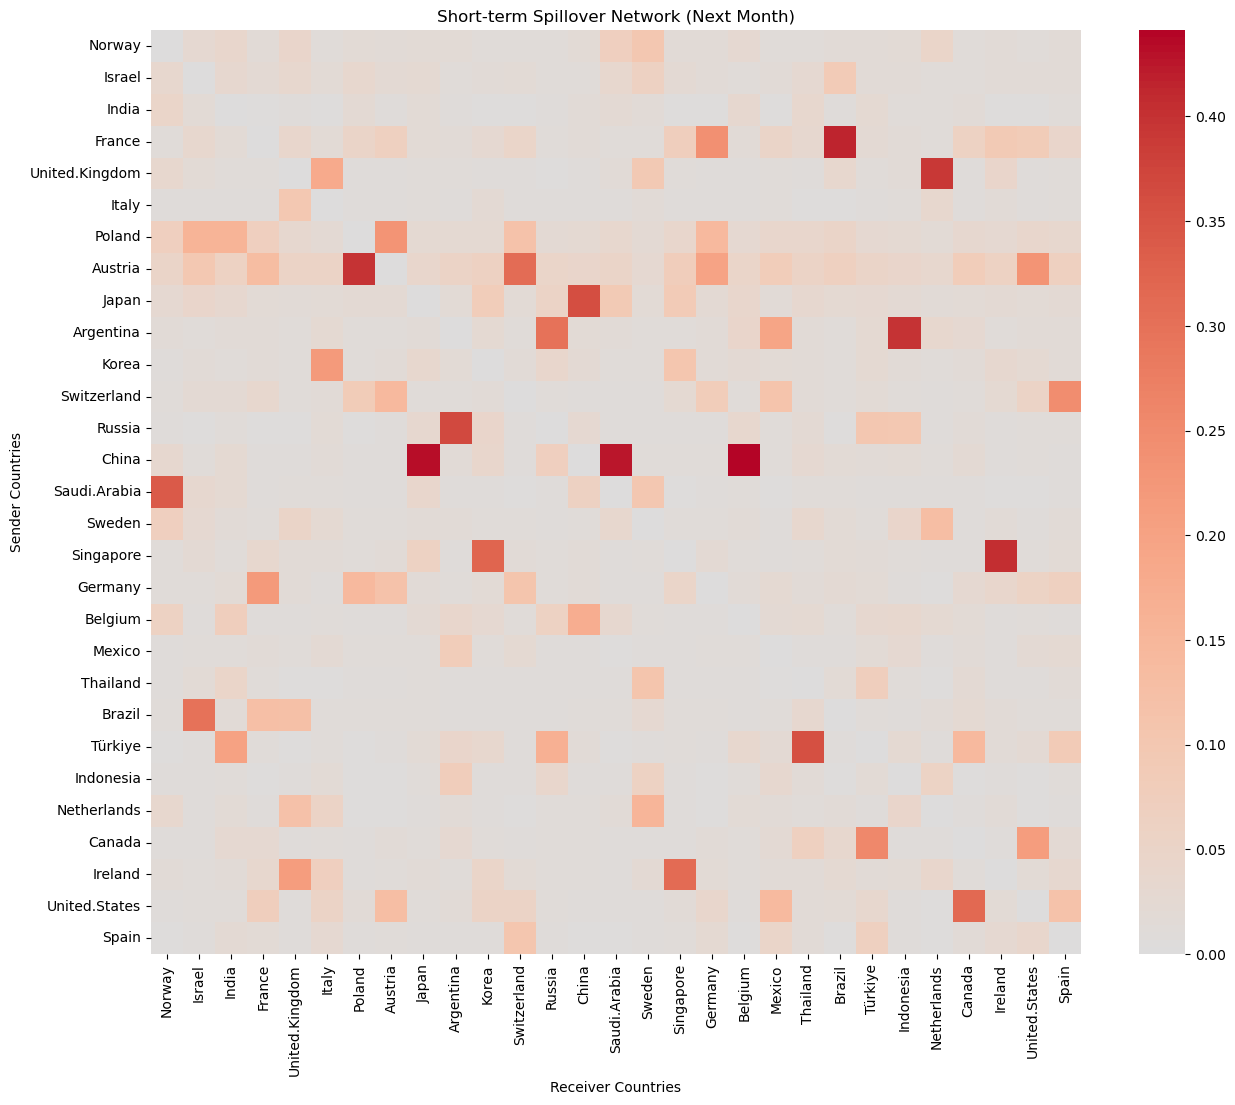

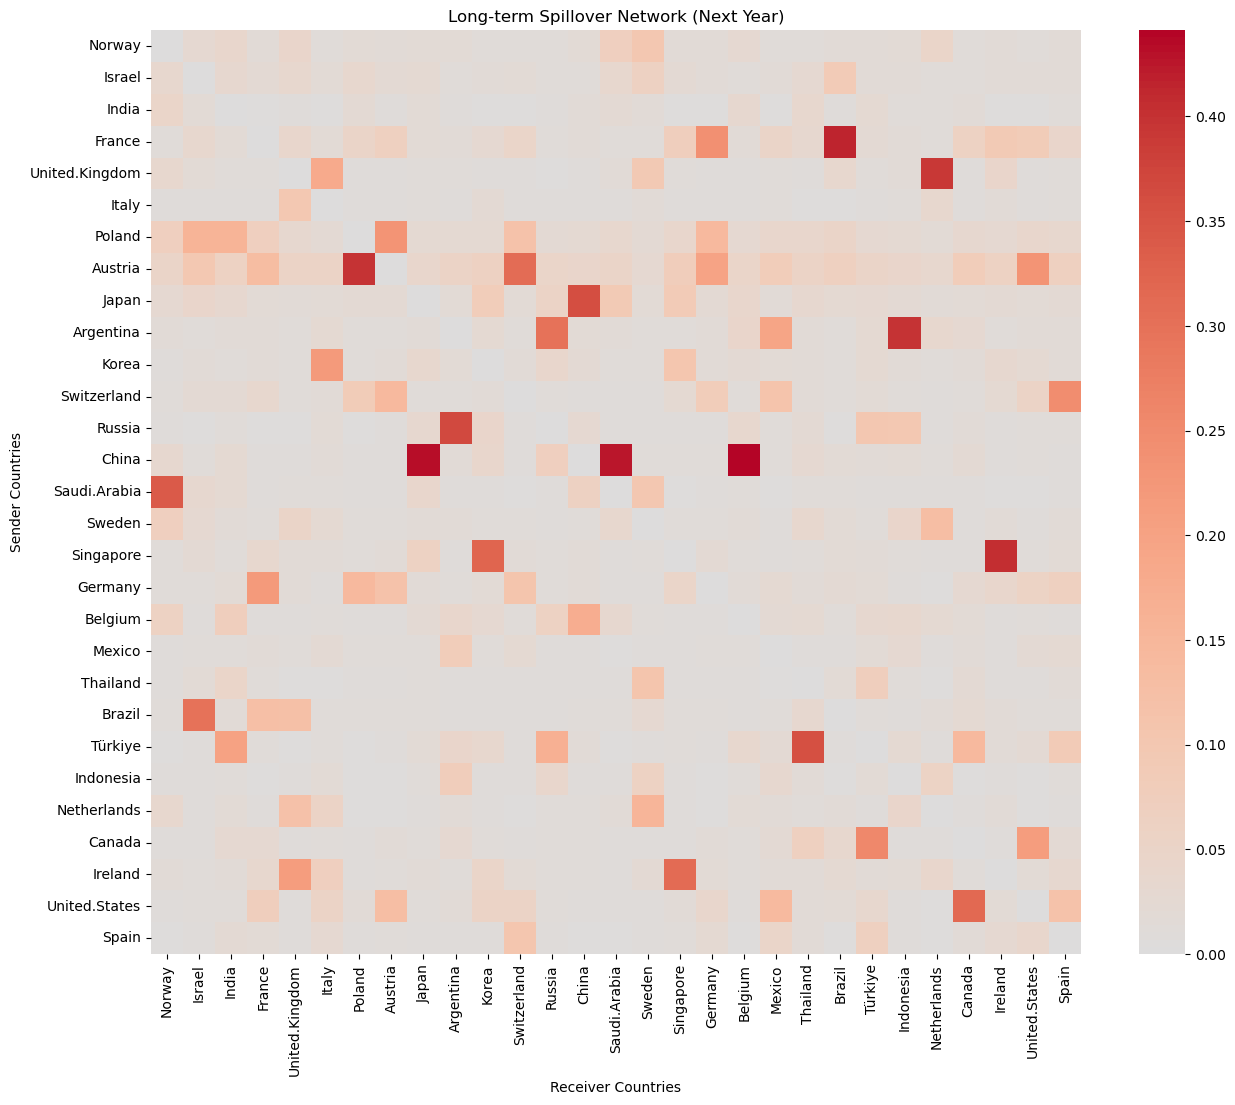

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ======= 1. 加载和预处理数据 =======
DATA_PATH = "C:/Users/rog/Desktop/Study/统模/Global-Inflation-Spillovers/new_data/final_cpi_data_filtered.csv"

# 读取数据（时间作为行索引，国家作为列）
data = pd.read_csv(DATA_PATH, index_col=0)  # index_col=0表示时间是行索引
countries = data.columns.tolist()  # 获取国家列表
print("国家列表:", countries)

# 检查数据结构
print("\n数据示例（前5行）：")
print(data.head())

# 标准化数据（按国家标准化）
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)  # 按国家标准化

# 检查数据中是否有NaN或inf
print("\n检查数据是否有NaN或inf值：")
print("NaN的数量:", np.isnan(scaled_data).sum())
print("Inf的数量:", np.isinf(scaled_data).sum())

# 用0填充NaN和inf值
scaled_data = np.nan_to_num(scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

print("\n标准化后数据示例（前5行）：")
print(scaled_data[:5, :])  # 显示前5个时间点，所有国家

# ======= 2. 构建图数据序列 =======
WINDOW_SIZE = 12  # 使用12个月历史数据

def create_graph_sequence(data, window_size=12):
    graphs = []
    n_times, n_countries = data.shape
    
    # 修改循环的范围，确保不会超出数据范围
    for t in range(window_size, n_times-12):  # 保证t+12不会超出数据范围
        # 节点特征（当前窗口内的数据）
        node_features = data[t-window_size:t, :].T  # 转置为（国家×时间窗口）
        
        # 边构建（移除相关性阈值，直接连接所有国家）
        edge_index = []
        edge_attr = []
        for i in range(n_countries):
            for j in range(n_countries):
                if i != j:
                    # 使用过去window_size数据进行计算
                    x = data[t-window_size:t, i]  # 过去的数据
                    y = data[t-window_size:t, j]  # 另一国家的过去数据
                    valid_mask = ~np.isnan(x) & ~np.isnan(y)
                    if np.sum(valid_mask) >= 6:  # 至少需要6个有效数据点
                        # 计算相关系数并使用它作为边的属性
                        corr = np.corrcoef(x[valid_mask], y[valid_mask])[0, 1]
                        edge_index.append([i, j])
                        edge_attr.append(corr)
        
        # 短期目标（下个月的通货膨胀率）
        short_term_target = data[t+1, :]
        
        # 长期目标（下一年的通货膨胀率）
        long_term_target = data[t+12, :]  # 一年后的通货膨胀率
        
        # 转换为PyG的Data对象
        graph = Data(
            x=torch.tensor(node_features, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1),
            y_short_term=torch.tensor(short_term_target, dtype=torch.float),
            y_long_term=torch.tensor(long_term_target, dtype=torch.float)
        )
        graphs.append(graph)
    return graphs


# 创建图序列
graph_sequence = create_graph_sequence(scaled_data, WINDOW_SIZE)
print(f"\n构建的图数量: {len(graph_sequence)}")
print("单图特征示例:", graph_sequence[0])

# ======= 3. 定义GAT模型 =======
class InflationGAT(nn.Module):
    def __init__(self, in_channels, out_channels=1, heads=4):
        super(InflationGAT, self).__init__()
        self.conv1 = GATConv(in_channels, 16, heads=heads, edge_dim=1)
        self.conv2 = GATConv(16*heads, 32, heads=2, edge_dim=1)
        self.short_term_predictor = nn.Sequential(
            nn.Linear(32*2, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )
        self.long_term_predictor = nn.Sequential(
            nn.Linear(32*2, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )
        
    def forward(self, data, return_attention=False):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # 第一层GAT（返回注意力权重）
        x, (edge_index1, att1) = self.conv1(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 第二层GAT
        x, (edge_index2, att2) = self.conv2(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 短期预测（下个月）
        short_term_pred = self.short_term_predictor(x)
        
        # 长期预测（下一年）
        long_term_pred = self.long_term_predictor(x)
        
        if return_attention:
            # 合并两层注意力权重并取平均
            combined_att = (att1.mean(dim=1) + att2.mean(dim=1)) / 2
            return short_term_pred.squeeze(), long_term_pred.squeeze(), combined_att
        return short_term_pred.squeeze(), long_term_pred.squeeze()

# ======= 4. 训练流程 =======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InflationGAT(in_channels=WINDOW_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# ======= 4. 训练流程 =======
def train(epochs=100):
    model.train()
    for epoch in range(epochs):
        total_epoch_loss = 0.0
        for graph in graph_sequence:
            graph = graph.to(device)
            optimizer.zero_grad()
            
            short_term_pred, long_term_pred = model(graph)
            
            short_term_loss = loss_fn(short_term_pred, graph.y_short_term)
            long_term_loss = loss_fn(long_term_pred, graph.y_long_term)
            loss = short_term_loss + long_term_loss
            
            loss.backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_epoch_loss += loss.item()
        
        avg_loss = total_epoch_loss / len(graph_sequence)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

train(epochs=200)

# ======= 5. 提取并可视化溢出网络 =======
def plot_spillover(matrix, title):
    plt.figure(figsize=(15, 12))
    sns.heatmap(matrix, 
               xticklabels=countries,
               yticklabels=countries,
               cmap="coolwarm",
               center=0,
               annot=False)
    plt.title(title)
    plt.xlabel("Receiver Countries")
    plt.ylabel("Sender Countries")
    plt.show()

# 提取短期网络（基于短期预测注意力）
model.eval()
with torch.no_grad():
    graph = graph_sequence[-1].to(device)
    short_term_pred, long_term_pred, attention = model(graph, return_attention=True)
    short_term_net = np.zeros((len(countries), len(countries)))
    edges = graph.edge_index.cpu().numpy().T
    for (src, dst), att in zip(edges, attention.cpu().numpy()):
        short_term_net[src, dst] = att
plot_spillover(short_term_net, "Short-term Spillover Network (Next Month)")

# 提取长期网络（基于长期预测注意力）
long_term_net = np.zeros((len(countries), len(countries)))
for (src, dst), att in zip(edges, attention.cpu().numpy()):
    long_term_net[src, dst] = att
plot_spillover(long_term_net, "Long-term Spillover Network (Next Year)")


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ======= 1. 加载和预处理数据 =======
DATA_PATH = "C:/Users/rog/Desktop/Study/统模/Global-Inflation-Spillovers/new_data/final_cpi_data_filtered.csv"

# 读取数据（时间作为行索引，国家作为列）
data = pd.read_csv(DATA_PATH, index_col=0)  # index_col=0表示时间是行索引
countries = data.columns.tolist()  # 获取国家列表
print("国家列表:", countries)

# 检查数据结构
print("\n数据示例（前5行）：")
print(data.head())

# 标准化数据（按国家标准化）
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)  # 按国家标准化

# 检查数据中是否有NaN或inf
print("\n检查数据是否有NaN或inf值：")
print("NaN的数量:", np.isnan(scaled_data).sum())
print("Inf的数量:", np.isinf(scaled_data).sum())

# 用0填充NaN和inf值
scaled_data = np.nan_to_num(scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

print("\n标准化后数据示例（前5行）：")
print(scaled_data[:5, :])  # 显示前5个时间点，所有国家

# ======= 2. 构建图数据序列 =======
WINDOW_SIZE = 12  # 使用12个月历史数据

def create_graph_sequence(data, window_size=12):
    graphs = []
    n_times, n_countries = data.shape
    
    # 修改循环的范围，确保不会超出数据范围
    for t in range(window_size, n_times-12):  # 保证t+12不会超出数据范围
        # 节点特征（当前窗口内的数据）
        node_features = data[t-window_size:t, :].T  # 转置为（国家×时间窗口）
        
        # 边构建（移除相关性阈值，直接连接所有国家）
        edge_index = []
        edge_attr = []
        for i in range(n_countries):
            for j in range(n_countries):
                if i != j:
                    # 使用过去window_size数据进行计算
                    x = data[t-window_size:t, i]  # 过去的数据
                    y = data[t-window_size:t, j]  # 另一国家的过去数据
                    valid_mask = ~np.isnan(x) & ~np.isnan(y)
                    if np.sum(valid_mask) >= 6:  # 至少需要6个有效数据点
                        # 计算相关系数并使用它作为边的属性
                        corr = np.corrcoef(x[valid_mask], y[valid_mask])[0, 1]
                        edge_index.append([i, j])
                        edge_attr.append(corr)
        
        # 短期目标（下个月的通货膨胀率）
        short_term_target = data[t+1, :]
        
        # 长期目标（下一年的通货膨胀率）
        long_term_target = data[t+12, :]  # 一年后的通货膨胀率
        
        # 转换为PyG的Data对象
        graph = Data(
            x=torch.tensor(node_features, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1),
            y_short_term=torch.tensor(short_term_target, dtype=torch.float),
            y_long_term=torch.tensor(long_term_target, dtype=torch.float)
        )
        graphs.append(graph)
    return graphs


# 创建图序列
graph_sequence = create_graph_sequence(scaled_data, WINDOW_SIZE)
print(f"\n构建的图数量: {len(graph_sequence)}")
print("单图特征示例:", graph_sequence[0])

# ======= 3. 定义GAT模型 =======
class InflationGAT(nn.Module):
    def __init__(self, in_channels, out_channels=1, heads=4):
        super(InflationGAT, self).__init__()
        self.conv1 = GATConv(in_channels, 16, heads=heads, edge_dim=1)
        self.conv2 = GATConv(16*heads, 32, heads=2, edge_dim=1)
        self.short_term_predictor = nn.Sequential(
            nn.Linear(32*2, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )
        self.long_term_predictor = nn.Sequential(
            nn.Linear(32*2, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )
        
    def forward(self, data, return_attention=False):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # 第一层GAT（返回注意力权重）
        x, (edge_index1, att1) = self.conv1(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 第二层GAT
        x, (edge_index2, att2) = self.conv2(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 短期预测（下个月）
        short_term_pred = self.short_term_predictor(x)
        
        # 长期预测（下一年）
        long_term_pred = self.long_term_predictor(x)
        
        if return_attention:
            # 合并两层注意力权重并取平均
            combined_att = (att1.mean(dim=1) + att2.mean(dim=1)) / 2
            return short_term_pred.squeeze(), long_term_pred.squeeze(), combined_att
        return short_term_pred.squeeze(), long_term_pred.squeeze()

# ======= 4. 训练流程 =======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InflationGAT(in_channels=WINDOW_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# ======= 4. 训练流程 =======
def train(epochs=100):
    model.train()
    all_attention_weights = []  # 用于存储所有时间点的注意力权重
    for epoch in range(epochs):
        total_epoch_loss = 0.0
        for graph in graph_sequence:
            graph = graph.to(device)
            optimizer.zero_grad()
            
            short_term_pred, long_term_pred, attention = model(graph, return_attention=True)
            
            short_term_loss = loss_fn(short_term_pred, graph.y_short_term)
            long_term_loss = loss_fn(long_term_pred, graph.y_long_term)
            loss = short_term_loss + long_term_loss
            
            loss.backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_epoch_loss += loss.item()
        
        avg_loss = total_epoch_loss / len(graph_sequence)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
        
        # 保存每个时间点的注意力权重
        all_attention_weights.append(attention.cpu().detach().numpy())
    
    return all_attention_weights

# 训练并获取所有时间点的注意力权重
all_attention_weights = train(epochs=500)

国家列表: ['Norway', 'Israel', 'India', 'France', 'United.Kingdom', 'Italy', 'Poland', 'Austria', 'Japan', 'Argentina', 'Korea', 'Switzerland', 'Russia', 'China', 'Saudi.Arabia', 'Sweden', 'Singapore', 'Germany', 'Belgium', 'Mexico', 'Thailand', 'Brazil', 'Türkiye', 'Indonesia', 'Netherlands', 'Canada', 'Ireland', 'United.States', 'Spain']

数据示例（前5行）：
           Norway    Israel     India    France  United.Kingdom     Italy  \
Date                                                                        
1月 2001       NaN       NaN       NaN       NaN             NaN       NaN   
2月 2001  0.739466 -0.292277 -0.000409  0.076148        0.024331  0.305515   
3月 2001  0.248562  0.242810 -0.141616  0.248794        0.245804  0.053752   
4月 2001  0.576571  0.170260  0.259519  0.374771        0.254242  0.295751   
5月 2001  0.619858  0.242291  0.295725  0.524983        0.705165  0.244895   

           Poland   Austria     Japan  Argentina  ...    Mexico  Thailand  \
Date                             

IndexError: Inconsistent shape between the condition and the input (got (841, 1) and (841,))

<Figure size 1500x1200 with 0 Axes>

Attention weights shape at time 0: (841,)


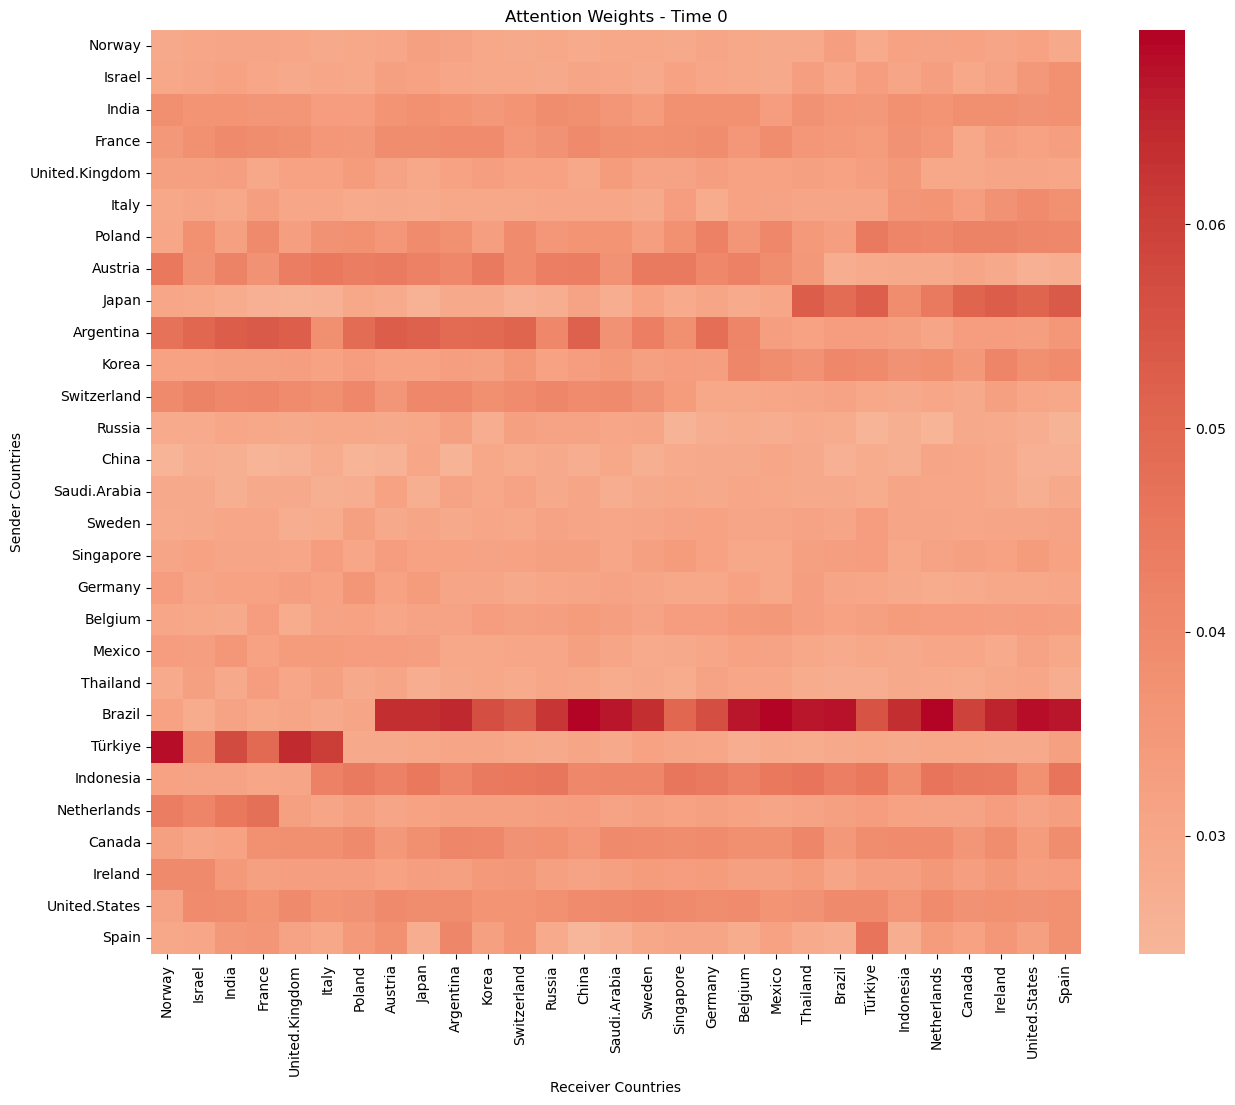

Attention weights shape at time 50: (841,)


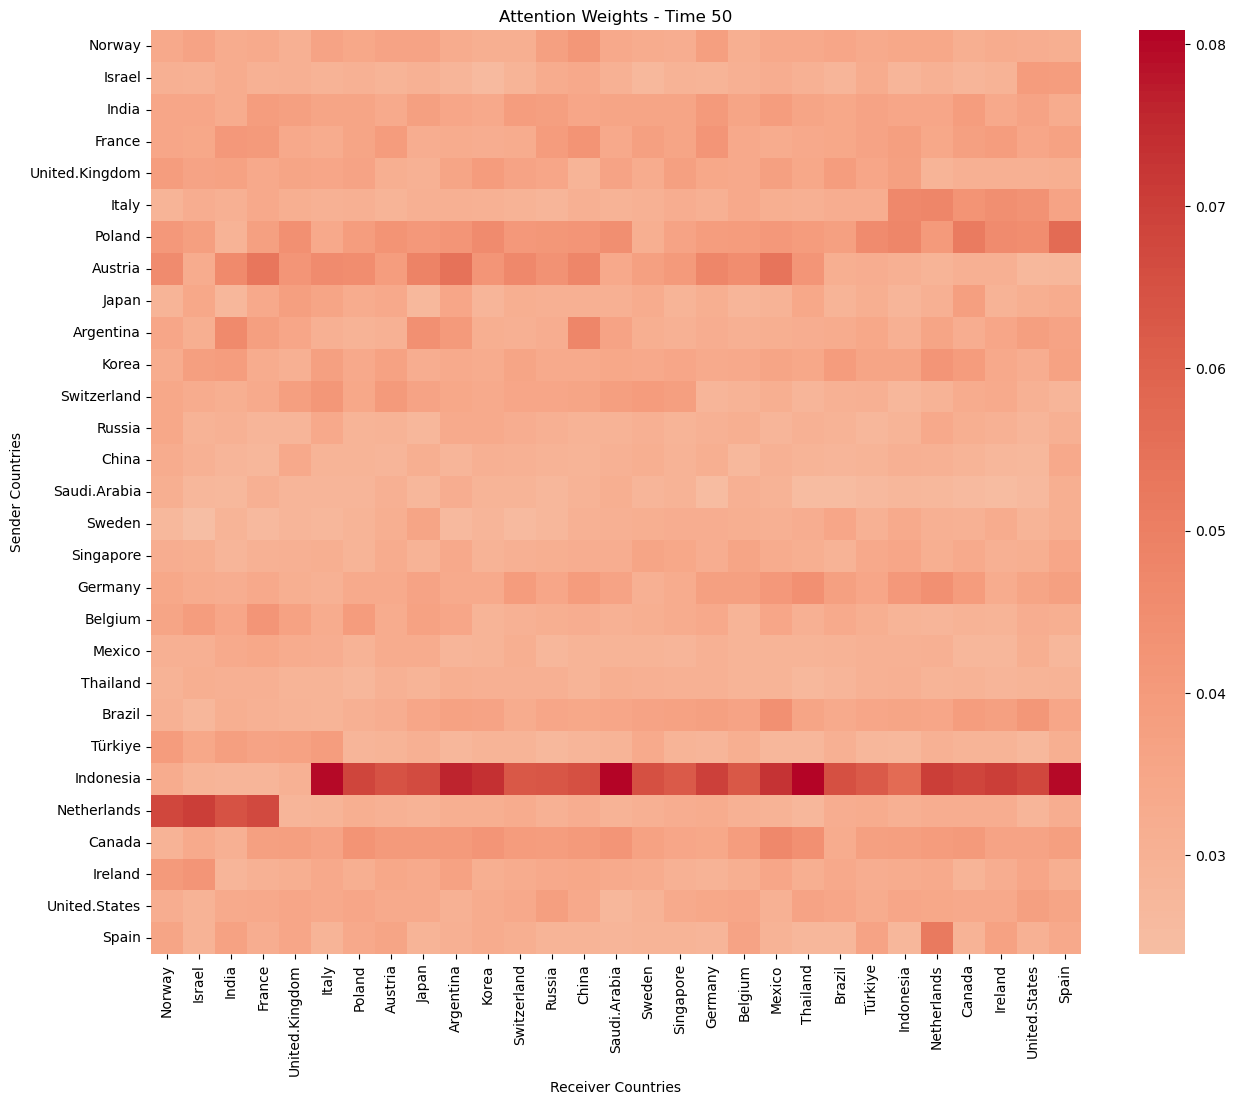

Attention weights shape at time 100: (841,)


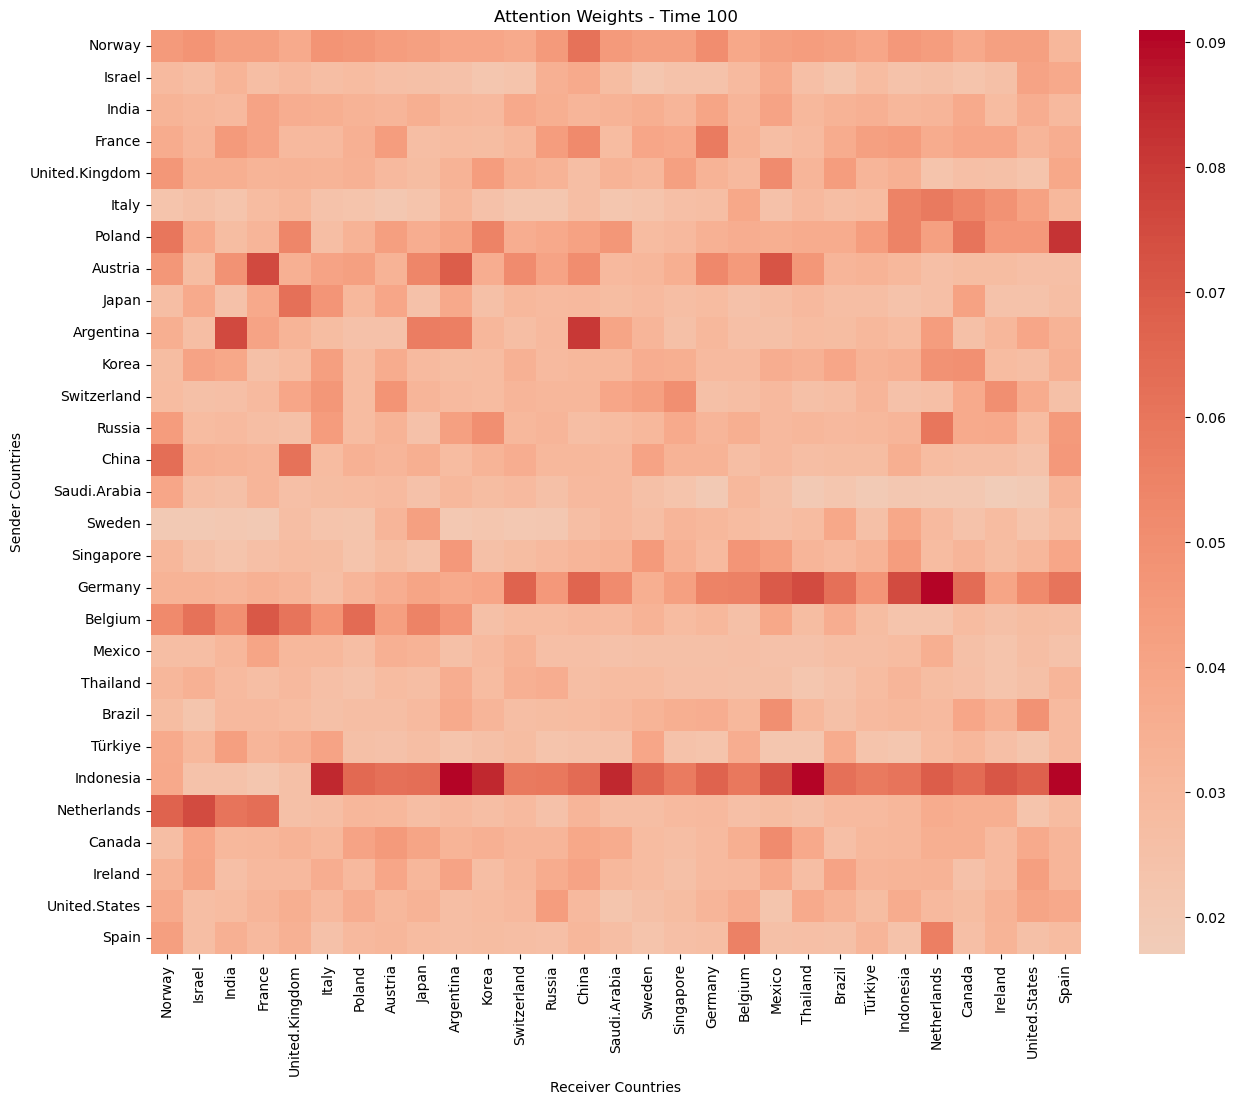

Attention weights shape at time 150: (841,)


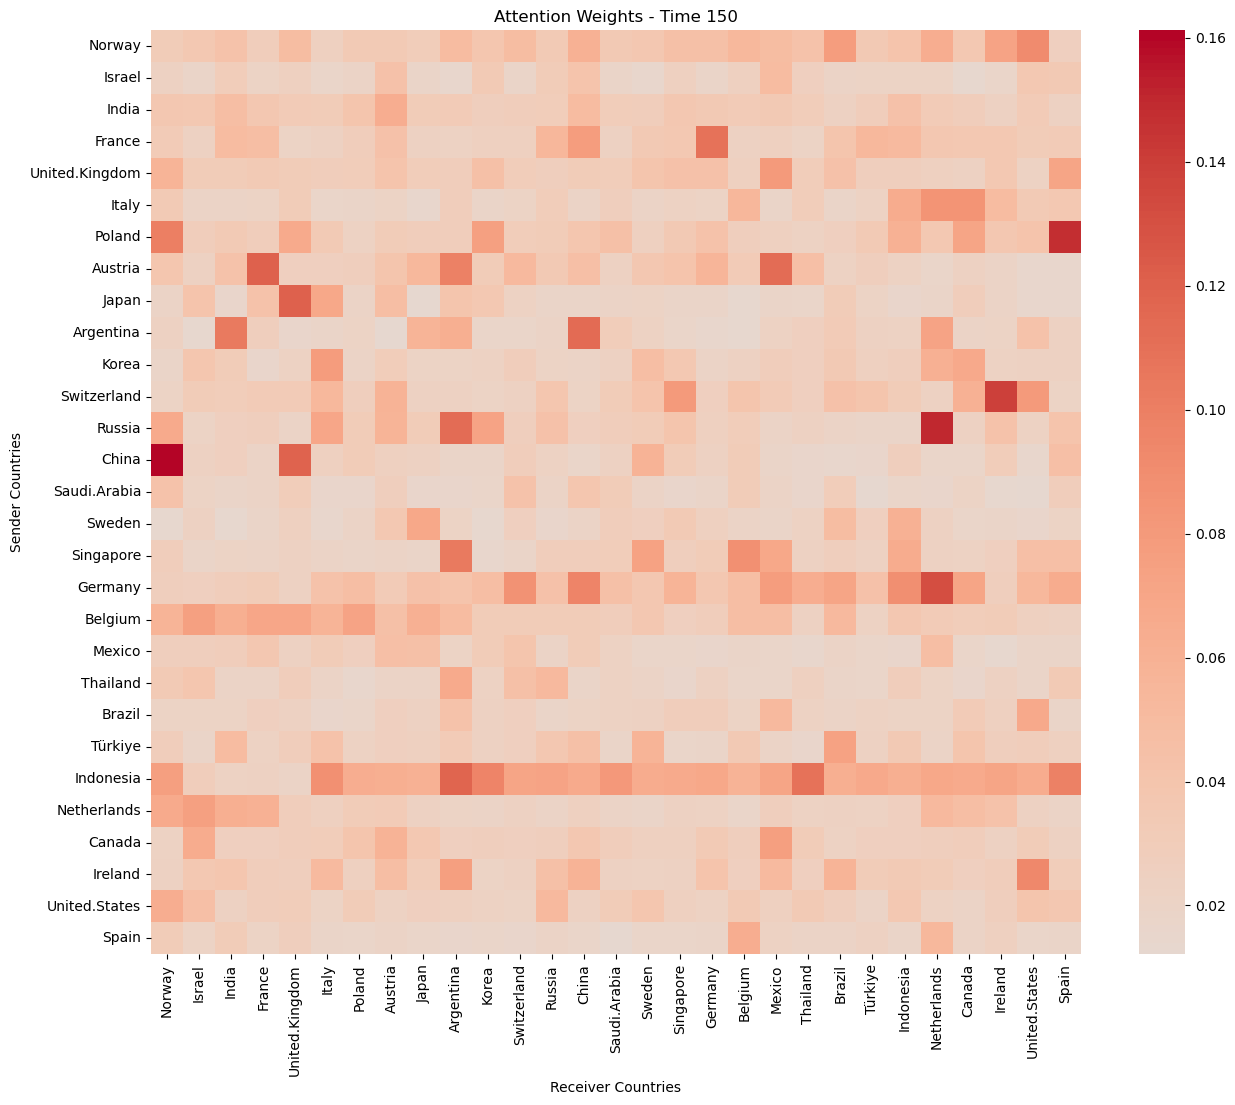

In [3]:
def plot_attention_weight(attention_weights, time_idx, title="Attention Weights"):
    print(f"Attention weights shape at time {time_idx}: {attention_weights.shape}")  # 打印形状以检查
    # 确保`attention_weights`是二维的（国家×国家的关系矩阵）
    if len(attention_weights.shape) == 1:
        # 如果是1D数组，将其调整为合适的形状，假设它应该是一个国家×国家的矩阵
        attention_weights = attention_weights.reshape((len(countries), len(countries)))
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(attention_weights, 
                xticklabels=countries,
                yticklabels=countries,
                cmap="coolwarm",
                center=0,
                annot=False)
    plt.title(f"{title} - Time {time_idx}")
    plt.xlabel("Receiver Countries")
    plt.ylabel("Sender Countries")
    plt.show()
time_points_to_plot = [0, 50, 100, 150]  # 选择不同的时间点进行可视化

for time_idx in time_points_to_plot:
    attention_weights = all_attention_weights[time_idx]
    plot_attention_weight(attention_weights, time_idx)

国家列表: ['Norway', 'Israel', 'India', 'France', 'United.Kingdom', 'Italy', 'Poland', 'Austria', 'Japan', 'Argentina', 'Korea', 'Switzerland', 'Russia', 'China', 'Saudi.Arabia', 'Sweden', 'Singapore', 'Germany', 'Belgium', 'Mexico', 'Thailand', 'Brazil', 'Türkiye', 'Indonesia', 'Netherlands', 'Canada', 'Ireland', 'United.States', 'Spain']

数据示例（前5行）：
           Norway    Israel     India    France  United.Kingdom     Italy  \
Date                                                                        
1月 2001       NaN       NaN       NaN       NaN             NaN       NaN   
2月 2001  0.739466 -0.292277 -0.000409  0.076148        0.024331  0.305515   
3月 2001  0.248562  0.242810 -0.141616  0.248794        0.245804  0.053752   
4月 2001  0.576571  0.170260  0.259519  0.374771        0.254242  0.295751   
5月 2001  0.619858  0.242291  0.295725  0.524983        0.705165  0.244895   

           Poland   Austria     Japan  Argentina  ...    Mexico  Thailand  \
Date                             

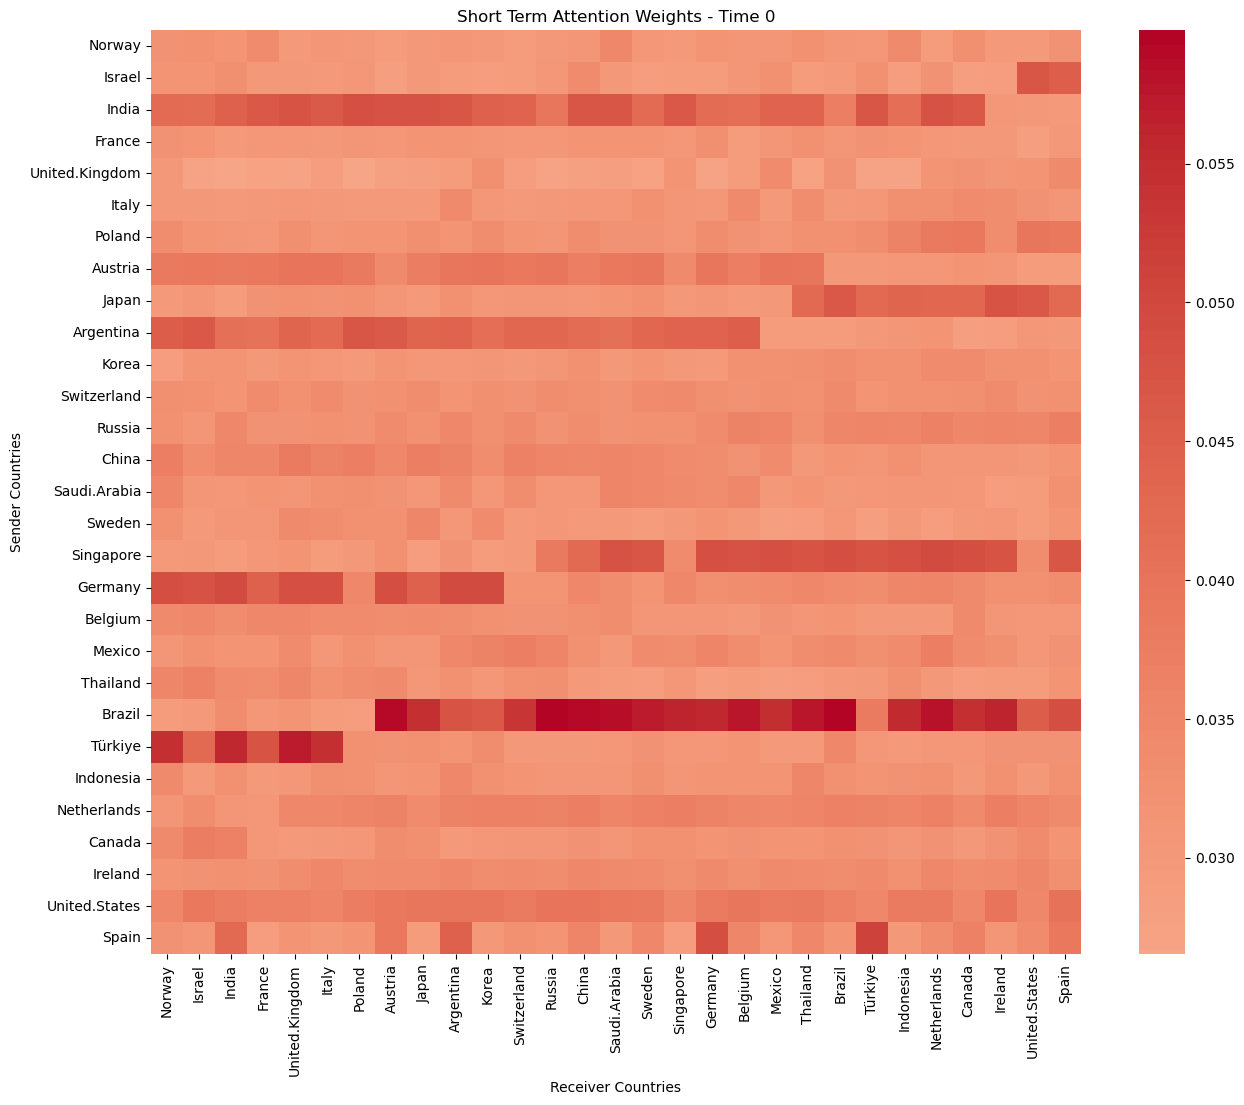

Attention weights shape at time 0: (841,)


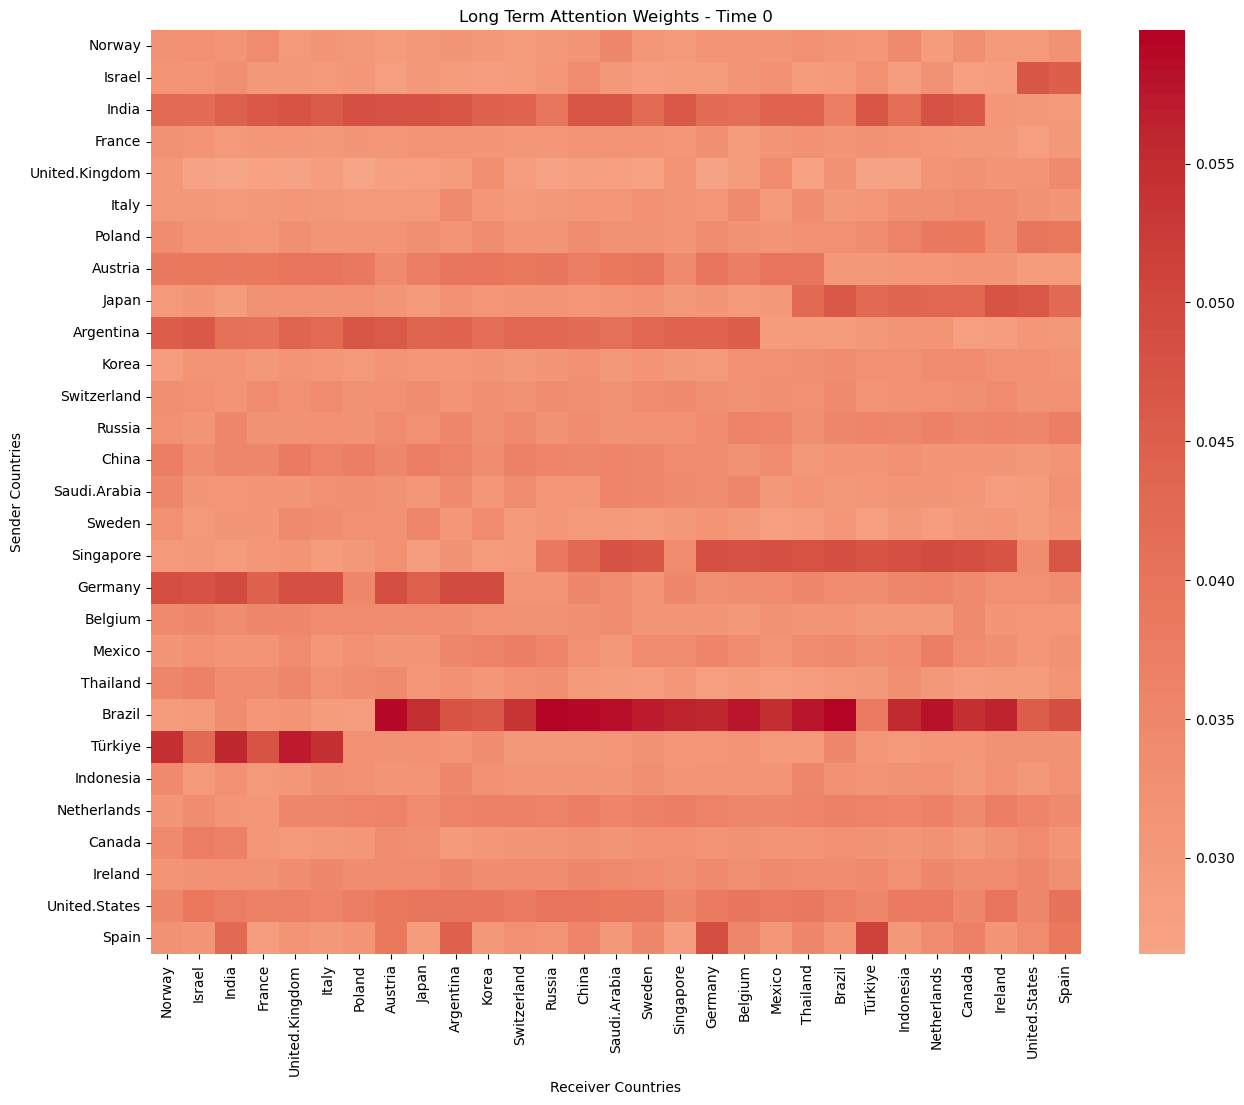

Attention weights shape at time 50: (841,)


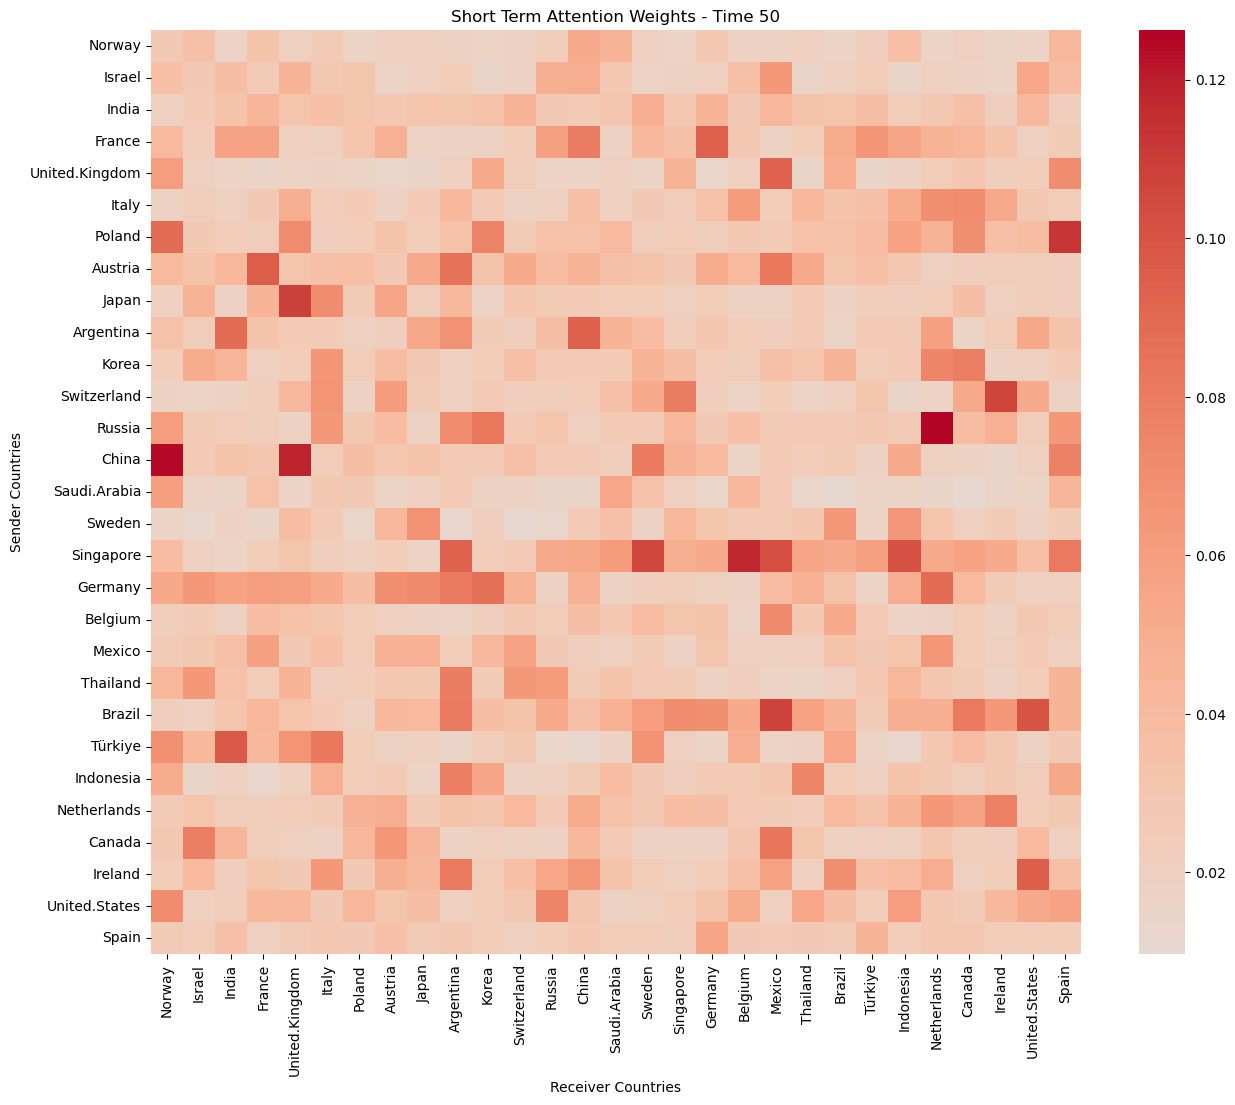

Attention weights shape at time 50: (841,)


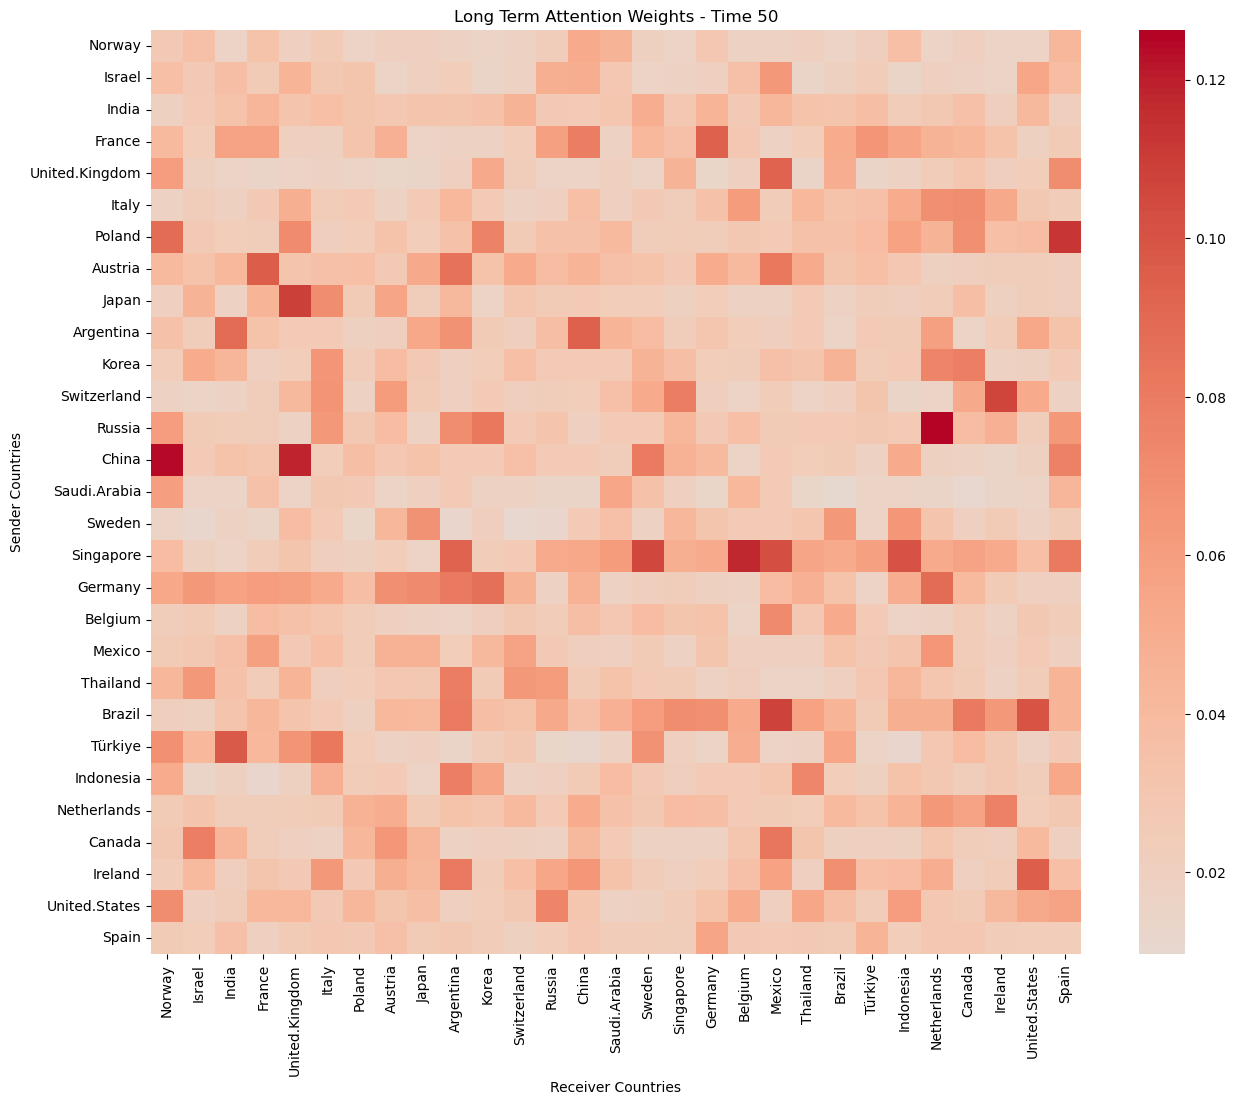

Attention weights shape at time 100: (841,)


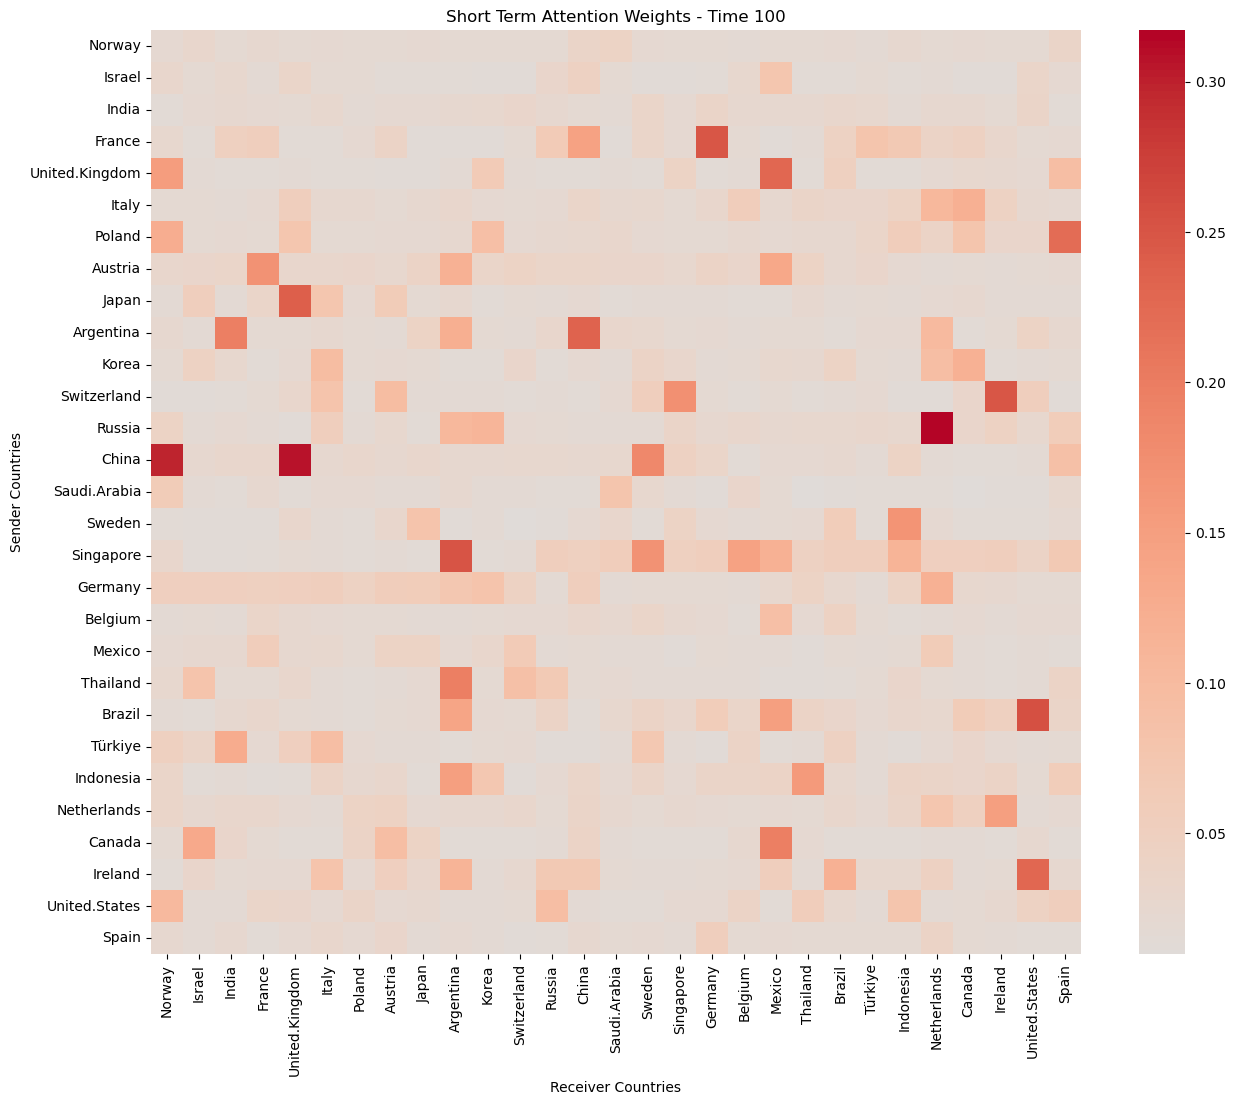

Attention weights shape at time 100: (841,)


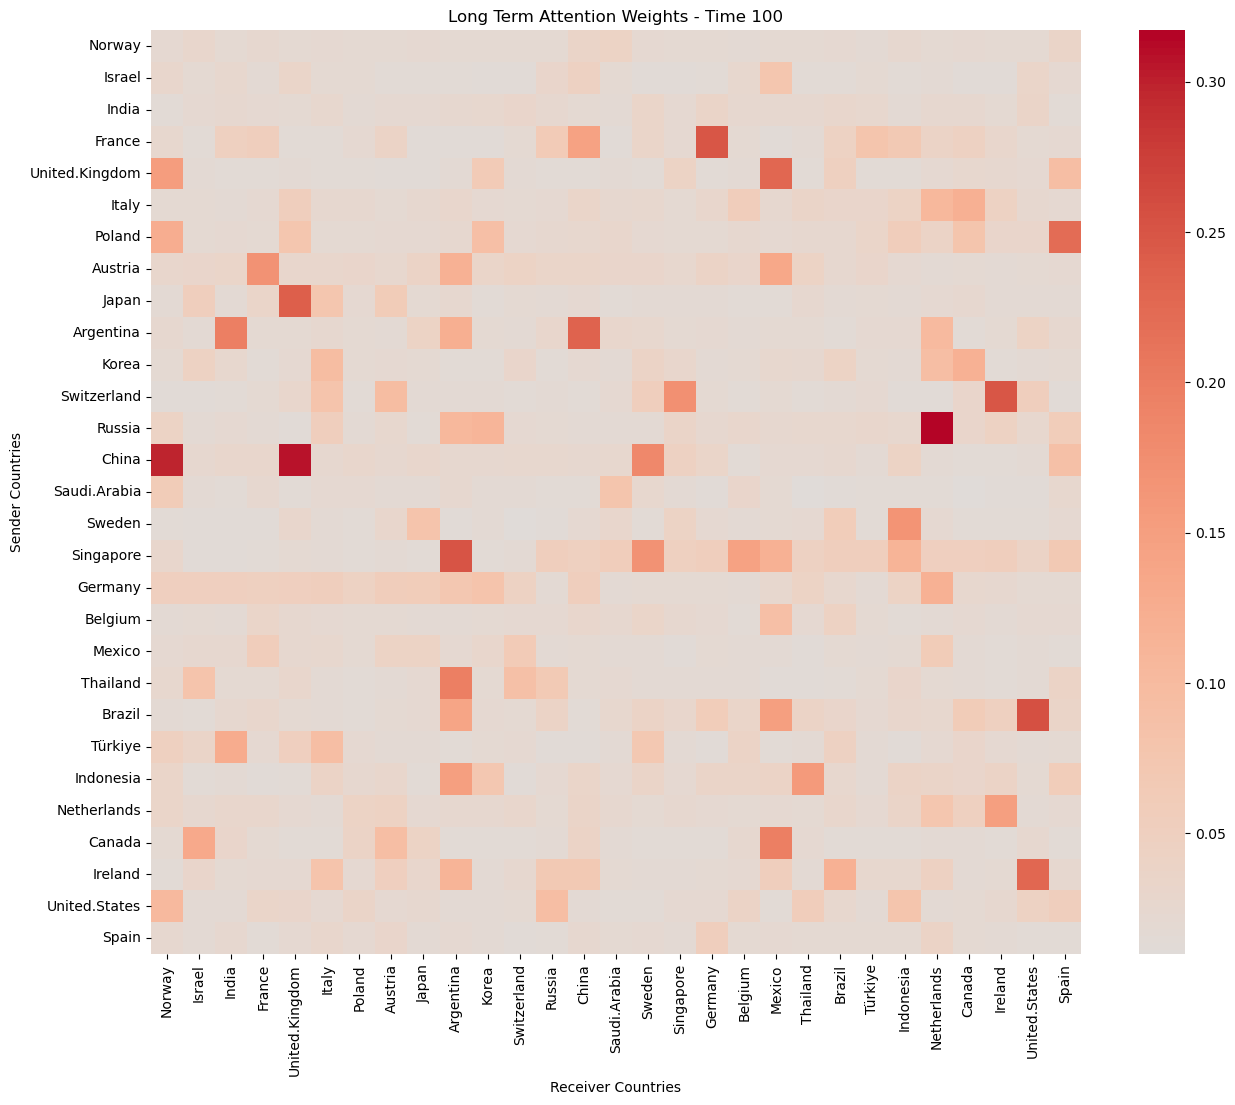

Attention weights shape at time 150: (841,)


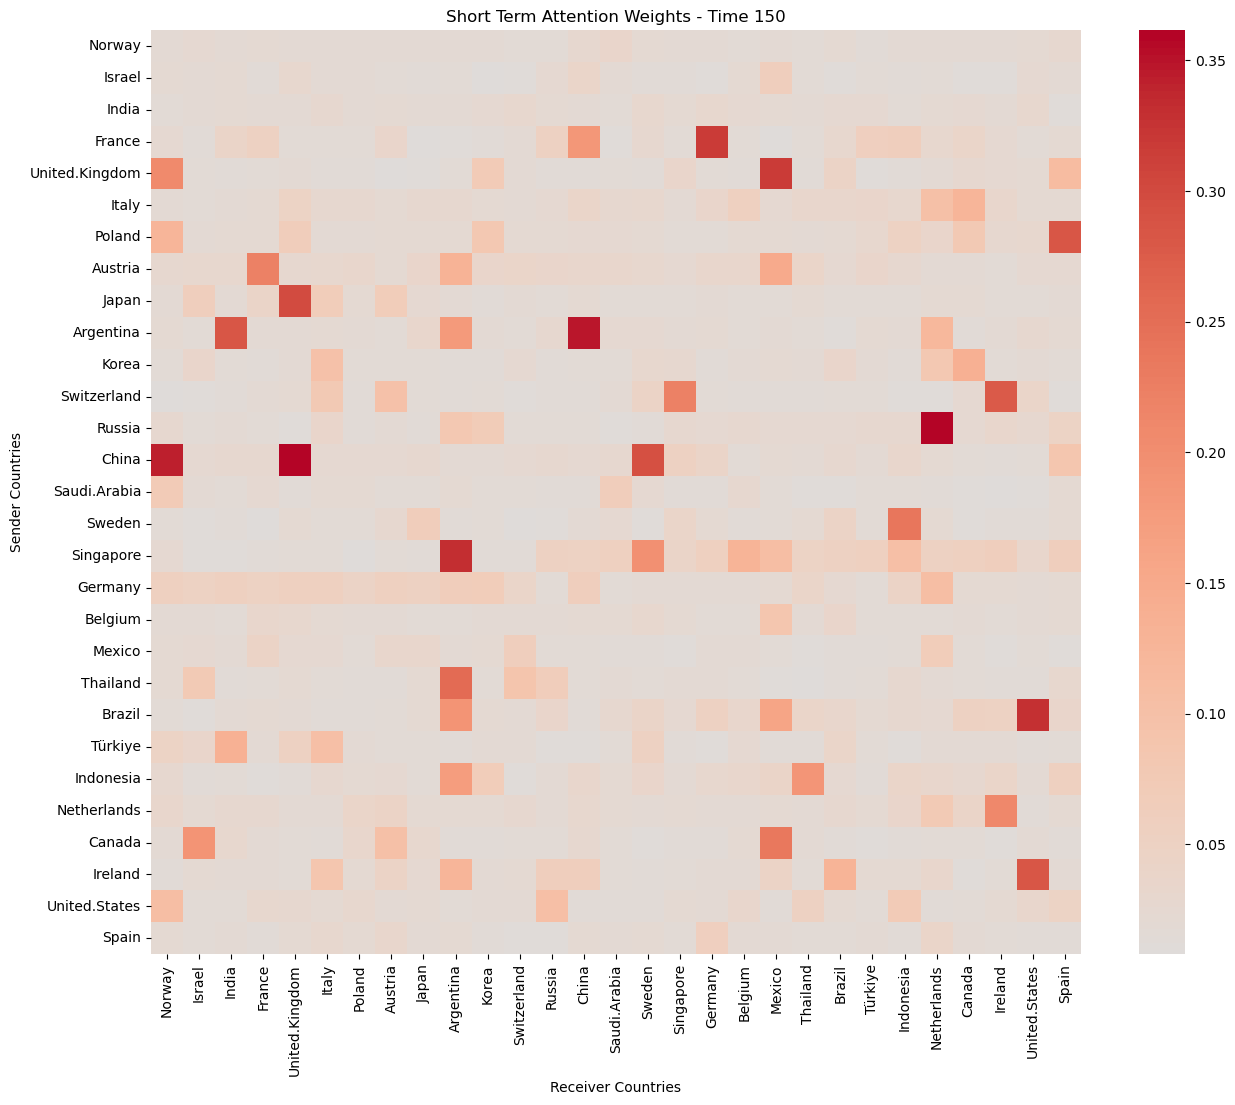

Attention weights shape at time 150: (841,)


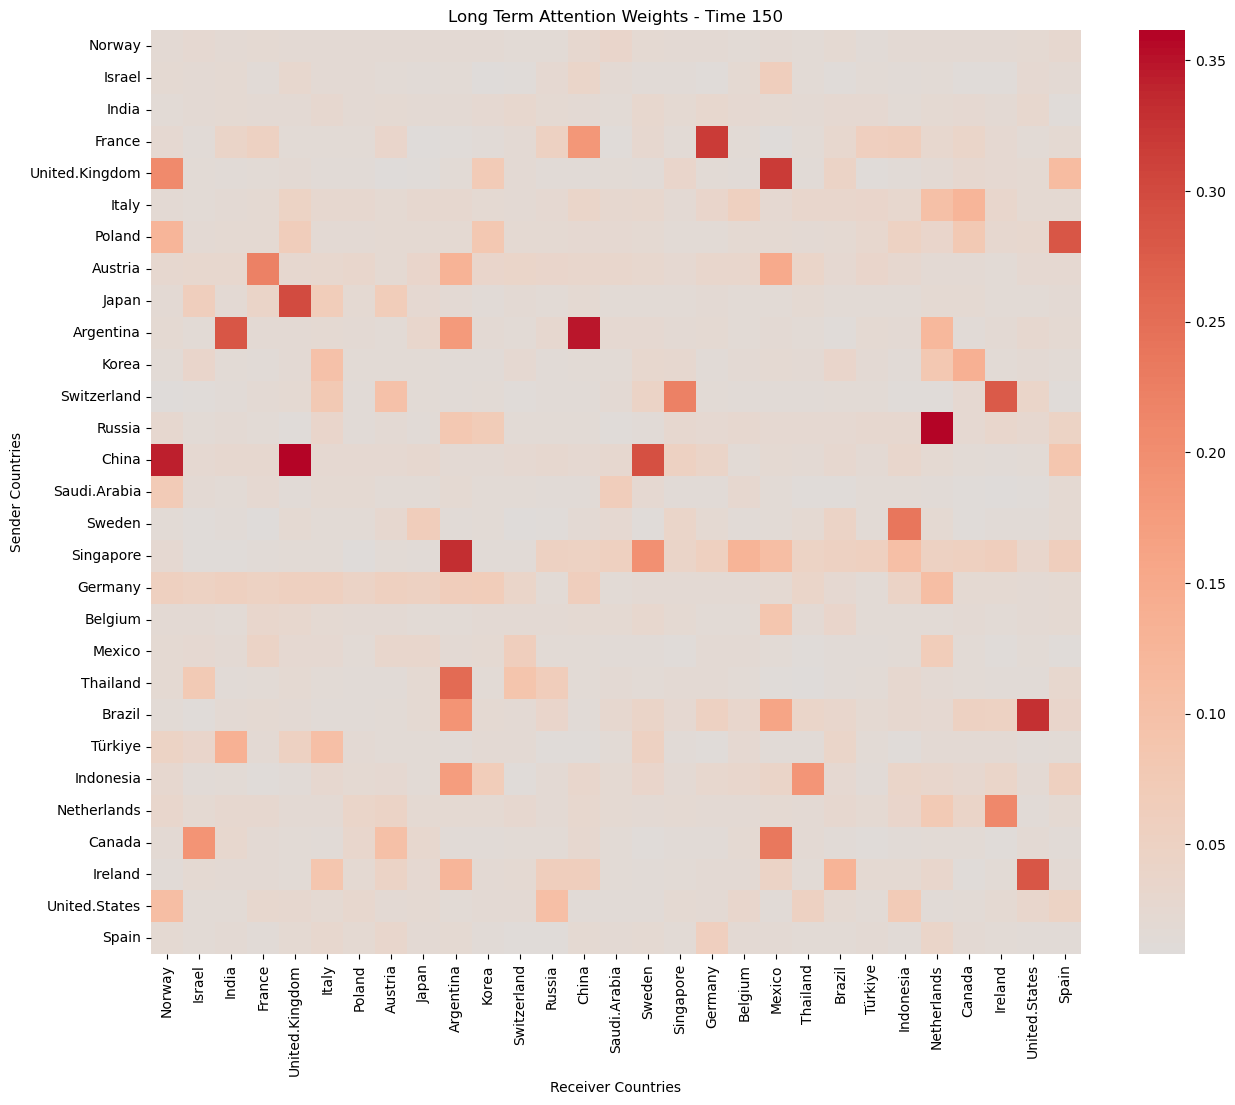

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ======= 1. 加载和预处理数据 =======
DATA_PATH = "C:/Users/rog/Desktop/Study/统模/Global-Inflation-Spillovers/new_data/final_cpi_data_filtered.csv"

# 读取数据（时间作为行索引，国家作为列）
data = pd.read_csv(DATA_PATH, index_col=0)  # index_col=0表示时间是行索引
countries = data.columns.tolist()  # 获取国家列表
print("国家列表:", countries)

# 检查数据结构
print("\n数据示例（前5行）：")
print(data.head())

# 标准化数据（按国家标准化）
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)  # 按国家标准化

# 检查数据中是否有NaN或inf
print("\n检查数据是否有NaN或inf值：")
print("NaN的数量:", np.isnan(scaled_data).sum())
print("Inf的数量:", np.isinf(scaled_data).sum())

# 用0填充NaN和inf值
scaled_data = np.nan_to_num(scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

print("\n标准化后数据示例（前5行）：")
print(scaled_data[:5, :])  # 显示前5个时间点，所有国家

# ======= 2. 构建图数据序列 =======
WINDOW_SIZE = 12  # 使用12个月历史数据

def create_graph_sequence(data, window_size=12):
    graphs = []
    n_times, n_countries = data.shape
    
    # 修改循环的范围，确保不会超出数据范围
    for t in range(window_size, n_times-12):  # 保证t+12不会超出数据范围
        # 节点特征（当前窗口内的数据）
        node_features = data[t-window_size:t, :].T  # 转置为（国家×时间窗口）
        
        # 边构建（移除相关性阈值，直接连接所有国家）
        edge_index = []
        edge_attr = []
        for i in range(n_countries):
            for j in range(n_countries):
                if i != j:
                    # 使用过去window_size数据进行计算
                    x = data[t-window_size:t, i]  # 过去的数据
                    y = data[t-window_size:t, j]  # 另一国家的过去数据
                    valid_mask = ~np.isnan(x) & ~np.isnan(y)
                    if np.sum(valid_mask) >= 6:  # 至少需要6个有效数据点
                        # 计算相关系数并使用它作为边的属性
                        corr = np.corrcoef(x[valid_mask], y[valid_mask])[0, 1]
                        edge_index.append([i, j])
                        edge_attr.append(corr)
        
        # 短期目标（下个月的通货膨胀率）
        short_term_target = data[t+1, :]
        
        # 长期目标（下一年的通货膨胀率）
        long_term_target = data[t+12, :]  # 一年后的通货膨胀率
        
        # 转换为PyG的Data对象
        graph = Data(
            x=torch.tensor(node_features, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1),
            y_short_term=torch.tensor(short_term_target, dtype=torch.float),
            y_long_term=torch.tensor(long_term_target, dtype=torch.float)
        )
        graphs.append(graph)
    return graphs


# 创建图序列
graph_sequence = create_graph_sequence(scaled_data, WINDOW_SIZE)
print(f"\n构建的图数量: {len(graph_sequence)}")
print("单图特征示例:", graph_sequence[0])

# ======= 3. 定义GAT模型 =======
class InflationGAT(nn.Module):
    def __init__(self, in_channels, out_channels=1, heads=4):
        super(InflationGAT, self).__init__()
        self.conv1 = GATConv(in_channels, 16, heads=heads, edge_dim=1)
        self.conv2 = GATConv(16*heads, 32, heads=2, edge_dim=1)
        self.short_term_predictor = nn.Sequential(
            nn.Linear(32*2, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )
        self.long_term_predictor = nn.Sequential(
            nn.Linear(32*2, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )
        
    def forward(self, data, return_attention=False):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # 第一层GAT（返回注意力权重）
        x, (edge_index1, att1) = self.conv1(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 第二层GAT
        x, (edge_index2, att2) = self.conv2(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.elu(x)
        
        # 短期预测（下个月）
        short_term_pred = self.short_term_predictor(x)
        
        # 长期预测（下一年）
        long_term_pred = self.long_term_predictor(x)
        
        if return_attention:
            # 合并两层注意力权重并取平均
            combined_att = (att1.mean(dim=1) + att2.mean(dim=1)) / 2
            return short_term_pred.squeeze(), long_term_pred.squeeze(), combined_att
        return short_term_pred.squeeze(), long_term_pred.squeeze()

# ======= 4. 训练流程 =======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InflationGAT(in_channels=WINDOW_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# ======= 4. 训练流程 =======
def train(epochs=100):
    model.train()
    all_attention_weights_short_term = []  # 用于存储短期注意力权重
    all_attention_weights_long_term = []  # 用于存储长期注意力权重
    for epoch in range(epochs):
        total_epoch_loss = 0.0
        for graph in graph_sequence:
            graph = graph.to(device)
            optimizer.zero_grad()
            
            short_term_pred, long_term_pred, attention = model(graph, return_attention=True)
            
            short_term_loss = loss_fn(short_term_pred, graph.y_short_term)
            long_term_loss = loss_fn(long_term_pred, graph.y_long_term)
            loss = short_term_loss + long_term_loss
            
            loss.backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_epoch_loss += loss.item()
        
        avg_loss = total_epoch_loss / len(graph_sequence)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
        
        # 保存每个时间点的注意力权重
        all_attention_weights_short_term.append(attention.cpu().detach().numpy())
        all_attention_weights_long_term.append(attention.cpu().detach().numpy())
    
    return all_attention_weights_short_term, all_attention_weights_long_term

# 训练并获取所有时间点的短期和长期注意力权重
all_attention_weights_short_term, all_attention_weights_long_term = train(epochs=500)

def plot_attention_weight(attention_weights, time_idx, countries, title="Attention Weights"):
    print(f"Attention weights shape at time {time_idx}: {attention_weights.shape}")  # 打印形状以检查
    # 确保`attention_weights`是二维的（国家×国家的关系矩阵）
    if len(attention_weights.shape) == 1:
        # 如果是1D数组，将其调整为合适的形状，假设它应该是一个国家×国家的矩阵
        attention_weights = attention_weights.reshape((len(countries), len(countries)))
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(attention_weights, 
                xticklabels=countries,
                yticklabels=countries,
                cmap="coolwarm",
                center=0,
                annot=False)
    plt.title(f"{title} - Time {time_idx}")
    plt.xlabel("Receiver Countries")
    plt.ylabel("Sender Countries")
    plt.show()

# 选择不同的时间点进行可视化
time_points_to_plot = [0, 50, 100, 150]

for time_idx in time_points_to_plot:
    attention_weights_short_term = all_attention_weights_short_term[time_idx]
    attention_weights_long_term = all_attention_weights_long_term[time_idx]
    
    # 绘制短期溢出效应
    plot_attention_weight(attention_weights_short_term, time_idx, countries, title="Short Term Attention Weights")
    
    # 绘制长期溢出效应
    plot_attention_weight(attention_weights_long_term, time_idx, countries, title="Long Term Attention Weights")
